In this proyect: 

1) I **scraped 40000 second hand cars** from [Milanuncios](https://www.milanuncios.com/coches-de-segunda-mano/?fromSearch=1&orden=relevance&pagina=1). One of the most famous second-hand online pages in Spain. 🚗🚓🚕💨

2) **Clean** and **get ready the data**. 🔄

2) **Analyzed the data** to answer questions such, in what cities can we find the best deals? 📈📊

3) Trained an algo to **predict the price** of second hand cars. 💲

In [24]:
# Data handling
import pandas as pd
import numpy as np
import datetime as dt
from functools import reduce

# Data scraping
from bs4 import BeautifulSoup
import requests
import csv
import re

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm 
from pandas.plotting import scatter_matrix
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio # to check px plot templates

# Splitting data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

#PCA
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

# Assesing model performance
from sklearn import metrics
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_val_score

# Tunning
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Save and load model
import pickle
import json
from pickle import load

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Library to display non-interactive vestion  of pyplots on githib and nbviewer
import plotly.io as pio

In [134]:
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [98]:
# Some issues currently exist to render the interactive pyplots on nbviewer. 
# As temporal solution we can set the render = svg to at least display non-interactive plots 

pio.renderers.default = "plotly_mimetype"

In [2]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 30)

## 1. Scrapping Data

In [ ]:
headers = requests.utils.default_headers()
headers.update({
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
})
title_list = []
location_list = []
description_list = []
ad_link_list = []
price_list = []
km_list = []
year_list = []
gear_list = []
doors_list = []
horsepower_list = []

km_regex = re.compile(r"^.*\b(kms)\b.*$")
year_regex = re.compile(r"^\d{4}$")
gear_regex = re.compile(r"^.*\b(Manual|Automático)\b.*$")
doors_regex = re.compile(r"^.*\b(puertas)\b.*$")
horsepower_regex = re.compile(r"^.*\b(CV)\b.*$")
car_detail_list = [[km_list, km_regex], [year_list, year_regex], [gear_list, gear_regex], [doors_list, doors_regex], [horsepower_list, horsepower_regex]]

scrape=0

while scrape < 100: # I noted that html_soup did not get all adds. 
    # Hence I use a while loop to keep scrapping the same pages to maximize the number of car adds scrapped
    
    for i in range(1,200):

        website = "https://www.milanuncios.com/coches-de-segunda-mano/?fromSearch=1&orden=relevance&pagina={}".format(i)
        source = requests.get(website, headers=headers).content
        html_soup = BeautifulSoup(source, 'lxml')
        add_html = html_soup.select("div.ma-AdCard-body")

        for n in range(len(add_html)):

            title_html = add_html[n].select("div h3 a")
            location_html = add_html[n].select("div a.ma-ContentListing-cardListingLink")
            description_html = add_html[n].select("div p")
            ad_link_html = add_html[n].select("div div a.ma-AdCard-gotoAd")
            price_html = add_html[n].select("div div div span.ma-AdCard-price")
            car_info_html = add_html[n].select("div div ul li span.ma-AdTag-label")

            for t in title_html:
                title_list.append((f"{i}-{n}-{scrape}", t.string.lower())) 
                # I add ID(f"{i}-{n}") to track the values for each add-car. 
                # This will facilitate the merging of dfs.
            for loc in location_html:
                location_list.append((f"{i}-{n}-{scrape}", loc["title"]))
            for d in description_html:
                description_list.append((f"{i}-{n}-{scrape}", d.text))
            for a in ad_link_html:
                ad_link_list.append((f"{i}-{n}-{scrape}", a["href"]))
            for p in price_html:
                price_list.append((f"{i}-{n}-{scrape}", p.text))
            if len(car_info_html) == 5:
                for z in range(len(car_info_html)):
                    for j in car_detail_list:
                        if (j[1].search(car_info_html[z].text)) != None:
                            j[0].append(((f"{i}-{n}-{scrape}"), (j[1].search(car_info_html[z].text)).group(0)))
    scrape += 1
    print(scrape)
    print(dt.datetime.now())


In [109]:
title = pd.DataFrame(title_list, columns =["ID", "title"])
location = pd.DataFrame(location_list, columns =["ID", "location"])
description = pd.DataFrame(description_list, columns =["ID", "description"])
link = pd.DataFrame(ad_link_list, columns =["ID", "link"])
km = pd.DataFrame(km_list, columns =["ID", "km"])
year = pd.DataFrame(year_list, columns =["ID", "year"]) 
gear = pd.DataFrame(gear_list, columns =["ID", "gear"]) 
doors = pd.DataFrame(doors_list, columns =["ID", "doors"]) 
horse = pd.DataFrame(horsepower_list, columns =["ID", "horse_power"]) 
price = pd.DataFrame(price_list, columns =["ID", "price(€)"]) 

In [112]:
df = reduce(lambda  left,right: pd.merge(left,right,on=['ID'],
                                            how='inner'), dfs) 
# joining multiple dfs on the ID column

Next I define some functions to clean up some of the data and turn it into the proper data type

In [113]:
def km_cleaner(item):
    return item.replace(" kms", "").replace(".", "")

In [114]:
def doors_cleaner(item):
    return item.replace(" puertas", "")

In [115]:
def horse_cleaner(item):
    return item.replace(" CV", "")

In [116]:
def price_cleaner(item):
    return item.replace("€", "").replace(".", "")

In [117]:
df["km"] = df["km"].apply(km_cleaner)
df["doors"] = df["doors"].apply(doors_cleaner)
df["horse_power"] = df["horse_power"].apply(horse_cleaner)
df["price(€)"] = df["price(€)"].apply(price_cleaner)

In [118]:
df["km"] = df["km"].astype(int)
df["doors"] = df["doors"].astype(int)
df["horse_power"] = df["horse_power"].astype(int)
df["year"] = df["year"].astype("datetime64[s]")
df["price(€)"] = df["price(€)"].astype(int)

In [120]:
df = df.drop("ID", axis=1)

In [18]:
# df.to_csv("cars.csv")

#### 1.1 Lets further scrape the **fuel, seller, full_description and date of add publication** using the previously scrapped urls

In [34]:
def get_seller(url):
    headers = requests.utils.default_headers()
    headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
    })
    source = requests.get(url, headers=headers).content
    html_soup = BeautifulSoup(source, 'lxml')
    try:
        seller = html_soup.select("div.pillDiv")[1].text
    except IndexError:
        seller="Unknown"
    return seller

In [40]:
def get_fuel(url):
    headers = requests.utils.default_headers()
    headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
    })
    source = requests.get(url, headers=headers).content
    fuel_regex = re.compile(r"diesel|gasolina")
    html_soup = BeautifulSoup(source, 'lxml')
    cardetails_html = html_soup.select("div.graphic-attributes-container")
    try:
        cardetails = cardetails_html[0].get_text(" ", strip=True)
        fuel = fuel_regex.search(cardetails).group(0)
    except (AttributeError, IndexError) as e:
        fuel="Unknown"
    return fuel    

In [36]:
def get_full_description(url):
    headers = requests.utils.default_headers()
    headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
    })
    source = requests.get(url, headers=headers).content
    html_soup = BeautifulSoup(source, 'lxml')
    try:
        description = html_soup.select("p.pagAnuCuerpoAnu")[0].text
    except IndexError:
        description = "Unknown"
    return description

In [790]:
def get_published_date(url):
    headers = requests.utils.default_headers()
    headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0',
    })
    source = requests.get(url, headers=headers).content
    html_soup = BeautifulSoup(source, 'lxml')
    try:
        date = html_soup.select("div.pagAnuStatsCreated")[0].text
    except IndexError:
        date = "Unknown"
    return date

In [791]:
df["date_advertised"] = df["link"].apply(get_published_date)

In [ ]:
df["fuel"] = df["link"].apply(get_fuel)

In [ ]:
df["seller"] = df["link"].apply(get_seller)

In [ ]:
df["full_description"] = df["link"].apply(get_full_description)

In [ ]:
# df.to_csv("cars.csv")

In [91]:
# df.to_csv(2nd_hand_cars_2020.csv)

## 2. Feature Engineering and Data Cleaning

In [41]:
df = pd.read_csv("Data\\2nd_hand_cars_2020.csv")

In [42]:
df = df.drop("Unnamed: 0", axis=1)

In [43]:
# replacing the full_description unknown with the description column
indexes_unknown = df.loc[df["full_description"]=="Unknown"]["full_description"].index

In [44]:
df.loc[indexes_unknown,"full_description"] = df.loc[indexes_unknown, "description"]

In [45]:
# replacing the unknown sellers with Professional
df.loc[(df["seller"] == "Unknown"), "seller"] = "Profesional"

In [46]:
df = df.drop("description", axis=1)

In [47]:
# Filling the nan values in the full_description column with No description
df["full_description"] = df["full_description"].fillna("No description")

### 2.1 Feature Engineering
* Description Len
* Parse Location
* Parse Brand
* Parse Model 
* Spain Region (Comunidad Autonoma)
* Brand class based on price

In [48]:
df["description_len"] = df["full_description"].apply(lambda x: len(x))

In [49]:
df[["brand", "region"]] = df["location"].str.split(" en ", expand=True)

In [50]:
df = df.drop("location", axis=1)

In [51]:
df.title[56]

'seat - ibiza 1.0 ecotsi 85kw 115cv fr'

In [52]:
regex_model = re.compile(r"\b(\w+)\b - \b(\w+)\b")

In [53]:
def model(item):
    if (regex_model.search(item)) != None:
        return (regex_model.search(item)).group(0)
    else:
        return item

In [54]:
df["model"] = df["title"].apply(model)

In [55]:
df["model"] = df["model"].str.replace(" -", "")

In [56]:
df["technical_service_mentioned"] = df["full_description"].apply(lambda x: 1 if "itv" in x.lower() else 0)

In [57]:
df["year"] = pd.to_datetime(df["year"], format="%Y-%m-%d") 

In [58]:
df["year"] = df["year"].apply(lambda x: x.year)

In [59]:
df["years_old"] = (dt.datetime.now().year - df["year"])

To obtain the spanish region to which every city belong I will use another dataset. [Download here](https://www.businessintelligence.info/varios/longitud-latitud-pueblos-espana.html)

In [60]:
df_cities = pd.read_excel(r"Data\\data_spanish_cities.xls")

In [61]:
df_cities["Provincia"] = df_cities["Provincia"].str.split("/", expand=True)[0]

In [62]:
df_cities.columns = df_cities.columns.str.replace("Provincia", "region")

In [63]:
vowels_list = [["á","a"],["é","e"],["í","i"],["ó","o"],["ú","u"]]

In [64]:
df_cities["region"] = df_cities["region"].str.lower()
for i, j in vowels_list:
    df_cities["region"] = df_cities["region"].str.replace(i, j)

In [65]:
df["region"] = df["region"].str.lower()
for i, j in vowels_list:
    df["region"] = df["region"].str.replace(i, j)

Lets join this new information adquired with our car df on the "region" column. But first we need to make sure the regions are named the same in both columns:

In [66]:
df["region"] = df["region"].str.replace("baleares", "illes balears")
df["region"] = df["region"].str.replace("bizkaia", "vizcaya")
df["region"] = df["region"].str.replace("ciudad_real", "ciudad real")
df["region"] = df["region"].str.replace("la_rioja", "la rioja")
df["region"] = df["region"].str.replace("la_coruna", "la coruna")
df["region"] = df["region"].str.replace("la coruna", "a coruña")
df["region"] = df["region"].str.replace("las_palmas", "las palmas")
df["region"] = df["region"].str.replace("tenerife", "santa cruz de tenerife")
df["region"] = df["region"].str.replace("santa cruz de santa cruz de santa cruz de tenerife", "santa cruz de tenerife")
df["region"] = df["region"].str.replace("la coruña", "a coruña")
df["region"] = df["region"].str.replace("gipuzkoa", "guipuzcoa")

In [67]:
df_cities.region.sort_values().unique() == df.region.sort_values().unique()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [68]:
df_cities

,Comunidad,region,Población,Latitud,Longitud,Altitud,Habitantes,Hombres,Mujeres
0,Andalucía,almeria,Abla,37.14114,-2.780104,871.16840,1504,783,721
1,Andalucía,almeria,Abrucena,37.13305,-2.797098,976.93870,1341,682,659
2,Andalucía,almeria,Adra,36.74807,-3.022522,10.97898,24373,12338,12035
3,Andalucía,almeria,Albánchez,37.28710,-2.181163,481.31230,815,422,393
4,Andalucía,almeria,Alboloduy,37.03319,-2.621750,388.43460,674,334,340
...,...,...,...,...,...,...,...,...,...
8107,Valencia,valencia,Xeresa,39.00910,-0.217992,34.05847,2221,1124,1097
8108,Valencia,valencia,Xirivella,39.46669,-0.427794,35.01973,30691,15474,15217
8109,Valencia,valencia,Yátova,39.38500,-0.808174,441.81140,2199,1140,1059
8110,Valencia,valencia,Yesa (La),39.49916,-0.426125,52.28455,260,141,119


In [69]:
region_p = pd.pivot_table(data=df_cities, index=["Comunidad", "region"],
         values=["Longitud", "Latitud", "Habitantes"], 
        aggfunc = {"Latitud": "mean" , "Longitud": "mean", "Habitantes": "sum"}).reset_index()

In [70]:
df = pd.merge(df, region_p, how="left", on="region")

In [71]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("habitantes", "population_region")

Next I will convert seller column into 0,1 so that we can use these column to calculate the percentage of profesionals and particular.

In [72]:
df["seller_bool"] = df["seller"].apply(lambda x: 1 if x == "Profesional" else 0)

Similarly, let's generate fuel_bool, where **diesel=1,  gasoline=0**, and gear_bool where **automatic=1, manual=0**

In [73]:
df["fuel_bool"] = df["fuel"].apply(lambda x: 1 if x == "diesel" else 0)

In [74]:
df["gear_bool"] = df["gear"].apply(lambda x: 1 if x == "Automático" else 0)

In [75]:
df["km/year"] = df["km"]/df["years_old"]

Furthermore, It will group the **brands into 5 different groups** based on the median price.

In [76]:
brand_p = pd.pivot_table(data=df, index=["brand"],
         values=["price(€)"], 
        aggfunc = {"price(€)": "median"}).reset_index()

In [77]:
brand_p = brand_p.sort_values(by= "price(€)")

In [78]:
brands_1 = list(brand_p["brand"].loc[(brand_p["price(€)"]< 3300)])

In [79]:
brands_2 = list(brand_p["brand"].loc[(brand_p["price(€)"]> 3500)&(brand_p["price(€)"] < 7000)])

In [80]:
brands_3 = list(brand_p["brand"].loc[(brand_p["price(€)"]>= 7000)&(brand_p["price(€)"] < 11000)])

In [81]:
brands_4 = list(brand_p["brand"].loc[(brand_p["price(€)"]>= 11000)&(brand_p["price(€)"] < 20000)])

In [82]:
brands_5 = list(brand_p["brand"].loc[(brand_p["price(€)"]>= 20000)])

In [83]:
def brand_classifier(item):

    if item in brands_1:
        return "Low"
    elif item in brands_2:
        return "Medium_Low"
    elif item in brands_3:
        return "Medium_High"
    elif item in brands_4:
        return "High"
    elif item in brands_5:
        return "Very_High"

In [84]:
df["brand_class"] = df["brand"].apply(brand_classifier)

Price classification

In [85]:
def price_classifier(item):
    if item < 1000:
        return "bargain"
    elif item >= 1000 and item < 4000:
        return "cheap"
    elif item >= 4000 and item < 10000:
        return "affordable"
    elif item >= 10000 and item < 15000:
        return "average"
    elif item >= 15000 and item < 25000:
        return "expensive"
    else:
        return "high-end"

In [86]:
df["price_class"] = df["price(€)"].apply(price_classifier)

#### 2.2 Data cleaning

This dataset still needs some cleaning due to the fact that there are adds:
* For rental
* For buying (not selling)
* Car pieces

Lets deal with this

First, lets inspect those adds with the words rent and per month and inspect and remove the **rental adds**. Since some adds offer the option of selling per month we need to take care not removing those.

In [87]:
# function to find proces per month in the description
def per_month_rent(item):
    if ("/mes" in item.lower()) | ("se alquila" in item.lower()):
        return 0
    else:
        return 1

In [88]:
df["final_price(1)_monthly(0)"] = df["full_description"].apply(per_month_rent)

In [89]:
df["final_price(1)_monthly(0)"].value_counts()

1    38531
0     1757
Name: final_price(1)_monthly(0), dtype: int64

In [90]:
#  indexes 2264, 4290, 4424, 5141, 15032, 26716, 26734, 29197
df.loc[((df["final_price(1)_monthly(0)"]==0)&(df["price(€)"] < 2000)&(df["km"] <= 2000))]

,title,link,km,year,gear,doors,horse_power,price(€),fuel,seller,...,population_region,latitud,longitud,seller_bool,fuel_bool,gear_bool,km/year,brand_class,price_class,final_price(1)_monthly(0)


In [91]:
df.loc[29].link

'https://www.milanuncios.com/bmw-de-segunda-mano/bmw-serie-5-525d-exclusive-363677926.htm'

In [92]:
# The only value to change correspond to index = 2264 -> real price 18500€
df["price(€)"].loc[df["link"] == 'https://www.milanuncios.com/mercedes-benz-de-segunda-mano/mercedes-benz-clase-cla-200-cdi-367545794.htm'] = 18500
df["price(€)"].loc[(df["link"] == 'https://www.milanuncios.com/renault-de-segunda-mano/renault-megane-s-t-zen-blue-dci-85-kw-115cv-367823968.htm')] = 17500
df["price(€)"].loc[(df["link"] == 'https://www.milanuncios.com/volkswagen-de-segunda-mano/volkswagen-golf-367635479.htm')] = 8000
# And we should drop index 29, 4290, 4424 since they are rental cars
df = df.loc[~(df["link"] == 'https://www.milanuncios.com/fiat-de-segunda-mano/fiat-500x-362880137.htm')]
df = df.reset_index(drop=True)

In [93]:
df["price(€)"].loc[(df["link"] == 'https://www.milanuncios.com/renault-de-segunda-mano/renault-megane-s-t-zen-blue-dci-85-kw-115cv-367823968.htm')] = 17500

In [94]:
df = df.loc[~((df["final_price(1)_monthly(0)"]==0)&(df["price(€)"] < 2000)&(df["km"] <= 2000))]

In [95]:
df = df.drop("final_price(1)_monthly(0)", axis=1)

In [96]:
df = df.loc[~(df["title"].str.contains("alquiler"))]
df = df.loc[~(df["full_description"].str.contains("Vehiculo exclusivo para alquiler"))]
df = df.loc[~(df["full_description"].str.contains("disponible para alquiler"))]

Next, filter those  adds about **buying cars** and **selling pieces**

In [97]:
df = df.loc[~((df["full_description"].str.contains("¿quieres vender tu coche?|Se compra toda clase de vehículos|Compro todo tipo de vehiculos|Compramos tu coche|Compramos su coche|compramos todo tipo|Compra y venta de autos usados|Compramos su coche|compramos su coche|Compro coches"))&(df["price(€)"] < 2000))]
df = df.loc[~((df["full_description"].str.contains("Vehículos desde"))&(df["price(€)"] < 600))]

In [98]:
df = df.loc[~((df["full_description"].str.contains("para piezas|para repuestos"))&(df["link"] != 'https://www.milanuncios.com/volkswagen-de-segunda-mano/volkswagen-passat-367726225.htm'))]
df = df.loc[~((df["full_description"].str.contains("Repuestos|repuestos|repuesto"))&(df["price(€)"] < 600))]

In [99]:
df = df.loc[~((df["full_description"].str.contains("reparamos"))&(df["price(€)"] < 1500))]

In [100]:
# Inspecting the cheapest offers we found other few adds that do not correspond to full-operational second hand cars
df = df.loc[~(df["link"].str.contains('https://www.milanuncios.com/ford-de-segunda-mano/ford-focus-367549880.htm\
                                |https://www.milanuncios.com/volkswagen-de-segunda-mano/volkswagen-golf-362326028.htm|\
                                https://www.milanuncios.com/volvo-de-segunda-mano/volvo-s40-367904385.htm|\
                                https://www.milanuncios.com/skoda-de-segunda-mano/skoda-octavia-364162145.htm|\
                                https://www.milanuncios.com/ford-de-segunda-mano/ford-c-max-368341322.htm|\
                                https://www.milanuncios.com/audi-de-segunda-mano/audi-a4-362781475.htm|\
                                https://www.milanuncios.com/seat-de-segunda-mano/seat-leon-367846873.htm|\
                                https://www.milanuncios.com/kia-de-segunda-mano/kia-carnival-367914311.htm|\
                                https://www.milanuncios.com/audi-de-segunda-mano/audi-a3-341807046.htm|\
                                https://www.milanuncios.com/bmw-de-segunda-mano/bmw-330d-368142284.htm|\
                                https://www.milanuncios.com/volkswagen-de-segunda-mano/volkswagen-golf-367635479.htm|\
                                https://www.milanuncios.com/bmw-de-segunda-mano/bmw-m4-linea-de-escape-original-365446997.htm|\
                                https://www.milanuncios.com/skoda-de-segunda-mano/skoda-superb-355278996.htm\
                                https://www.milanuncios.com/bmw-de-segunda-mano/bmw-m4-linea-de-escape-original-365446997.htm'))]


In [101]:
df = df.reset_index(drop=True)

In [102]:
df.shape

(40274, 28)

In [103]:
df.to_csv("Data\\2nd_hand_cars_clean.csv")

## 3. Exploratory Data Analyses

In [5]:
df = pd.read_csv("Data\\2nd_hand_cars_clean.csv")

In [6]:
df = df.drop("Unnamed: 0", axis=1)

Lets get a sense of the presence of outliers using boxplots and distribution of the data with histograms

In [7]:
df

,title,link,km,year,gear,doors,horse_power,price(€),fuel,seller,...,comunidad,population_region,latitud,longitud,seller_bool,fuel_bool,gear_bool,km/year,brand_class,price_class
0,skoda - octavia 1.9 tdi active,https://www.milanuncios.com/skoda-de-segunda-m...,158000,2005,Manual,5,105,3999,diesel,Profesional,...,Andalucía,907428,37.180734,-3.415732,1,1,0,1.053333e+04,Medium_High,cheap
1,audi - s5 cabrio 3.0 tfsi 333cv quattro s tronic,https://www.milanuncios.com/audi-de-segunda-ma...,69900,2014,Automático,2,333,25990,gasolina,Profesional,...,Castilla León,375563,42.248227,-3.596478,1,0,1,1.165000e+04,High,high-end
2,toyota - land cruiser 2.8 d4d vxl auto,https://www.milanuncios.com/toyota-de-segunda-...,8000,2020,Automático,5,177,53890,diesel,Profesional,...,Madrid,6386932,40.545579,-3.694533,1,1,1,inf,Medium_High,high-end
3,bmw - serie 3 320d,https://www.milanuncios.com/bmw-de-segunda-man...,48100,2015,Automático,4,184,22850,diesel,Profesional,...,Castilla León,375563,42.248227,-3.596478,1,1,1,9.620000e+03,High,expensive
4,audi - q5 2.0 tdi 143cv ambition,https://www.milanuncios.com/audi-de-segunda-ma...,167000,2013,Manual,5,143,17900,diesel,Profesional,...,Castilla León,354608,40.798442,-5.959213,1,1,0,2.385714e+04,High,expensive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40269,volkswagen - polo 1.6 tdi 90cv advance,https://www.milanuncios.com/volkswagen-de-segu...,141000,2012,Manual,3,90,7950,diesel,Profesional,...,Catalunya,5487935,41.680817,2.032265,1,1,0,1.762500e+04,High,affordable
40270,peugeot - 308 5p style 1.6 bluehdi 120,https://www.milanuncios.com/peugeot-de-segunda...,86000,2016,Manual,5,120,10500,diesel,Profesional,...,Galicia,959764,42.375026,-8.573065,1,1,0,2.150000e+04,Medium_High,average
40271,renault - clio,https://www.milanuncios.com/renault-de-segunda...,186000,2003,Manual,5,65,2200,diesel,Profesional,...,Galicia,1145488,43.131834,-8.470293,1,1,0,1.094118e+04,Medium_Low,cheap
40272,ford - kuga 1.5 tdci 88kw 4x2 ass trend,https://www.milanuncios.com/ford-de-segunda-ma...,20304,2018,Manual,5,120,16690,diesel,Profesional,...,Madrid,6386932,40.545579,-3.694533,1,1,0,1.015200e+04,Medium_High,expensive


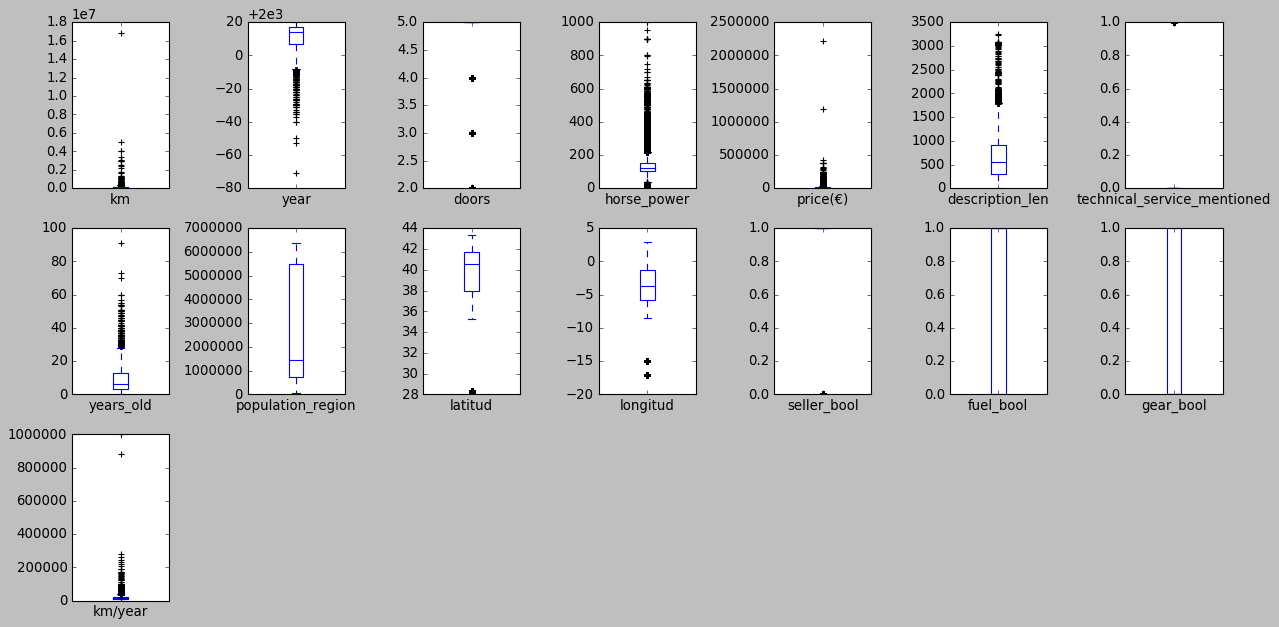

In [5]:
plt.style.use("classic")
df.plot(kind='box', subplots=True, layout=(3,7), sharex=False, sharey=False, figsize=(16,8), color="b")
plt.tight_layout()
# plt.savefig("boxplots", dpi=400)
plt.show()

Lets handle some obvious outliers

In [6]:
df = df[~(df["price(€)"] > 500000)]

In [7]:
df = df[~(df["km"] > 10000000)]

In [8]:
# several models display  horse power larger than what their model should. lets subtitute these values witht the median
horse_median = df["horse_power"].median()
df["horse_power"].loc[((df["horse_power"] >= 600))&(df["price(€)"]<5000)] = horse_median

In [9]:
# Replacing those infinite values for the cars with 0 years with the km column
df["km/year"].loc[(df["km/year"] == float("inf"))] = df["km"] 

In [10]:
# It is safe to say that driving more than a 900000km per year is impossible (2500km per day)
df = df[~(df["km/year"] > 900000)]

In [11]:
# Also, lets remove cars with price = 0. 
# It is sometimes the case in which other car-related services are listed with price 0
df = df.loc[~(df["price(€)"]==0)]

In [12]:
df = df.reset_index(drop=True)

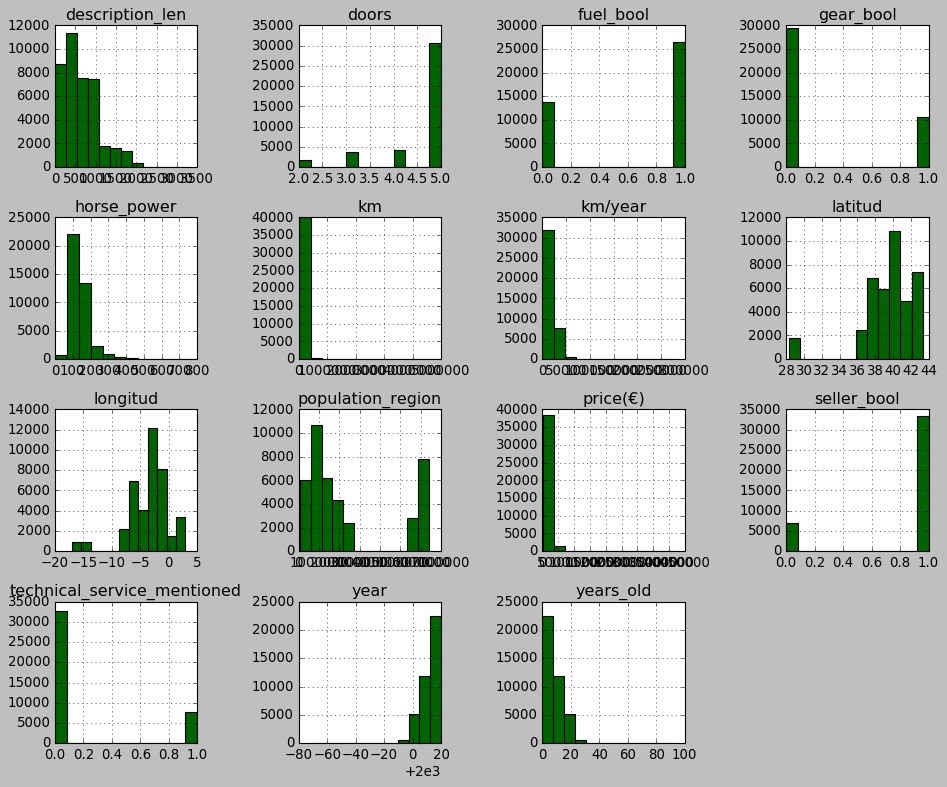

In [13]:
plt.rcParams["figure.figsize"] = (12,10)
df.hist(bins=12, color="darkgreen")
plt.tight_layout()
# plt.savefig("hist_features.png", dpi=400)
plt.show()

Main questions to answer:

   1) What regions in Spain sells the cheaper/ most expensive cars -> Map it
   2) What are the cheapest cars. Make a list of best offers.
   
   3) What brands/models are more reliable based on the km
   
   4) Feature Selection for the model. Look for correlations

### 3.1 Mapping the Car Prices in the different Spanish Regions

First, lets make a **map plot** to visualy analyze the difference in car prices among different spanish regions. For this, lets first generate a dataframe with the needed information.
For this I will create a **pivot table** and use the **median()** as aggregate functions for those attributes containing more sparse data, while **mean()** will be used for less sparce data (see boxplots).

In [8]:
df_map = pd.pivot_table(data=df, index=["comunidad", "region"], 
              values=["latitud", "longitud", "population_region", "years_old", "price(€)", "horse_power", "seller_bool", "km", "km/year"],
              aggfunc = {"latitud": "mean", "longitud": "mean", "population_region": "mean", "seller_bool": "mean", "km":"median", "km/year":"median",
                        "years_old": "median", "horse_power": "median", "price(€)": ["median", "count"]}).reset_index()

In [9]:
df_map.columns

MultiIndex([(        'comunidad',       ''),
            (           'region',       ''),
            (      'horse_power', 'median'),
            (               'km', 'median'),
            (          'km/year', 'median'),
            (          'latitud',   'mean'),
            (         'longitud',   'mean'),
            ('population_region',   'mean'),
            (         'price(€)',  'count'),
            (         'price(€)', 'median'),
            (      'seller_bool',   'mean'),
            (        'years_old', 'median')],
           )

In [10]:
df_map.columns = ['comunidad', 'region', 'horse_power', 'km', 'km/year', 'latitud', 'longitud',
                  'population_region', 'number_cars', 'price(€)', 'percentage_professional', 'years_old']

In [11]:
df_map = df_map.sort_values(by="years_old")

In [12]:
df_map["percentage_professional"] = round((df_map["percentage_professional"]*100),1)

In [13]:
df_map["adds_per_1000_people"] = round(df_map["number_cars"]/(df_map["population_region"]/1000),1)

In [14]:
df_map["region"] = df_map["region"].str.capitalize() 

In [15]:
df_map["km/year"] = round(df_map["km/year"],1)

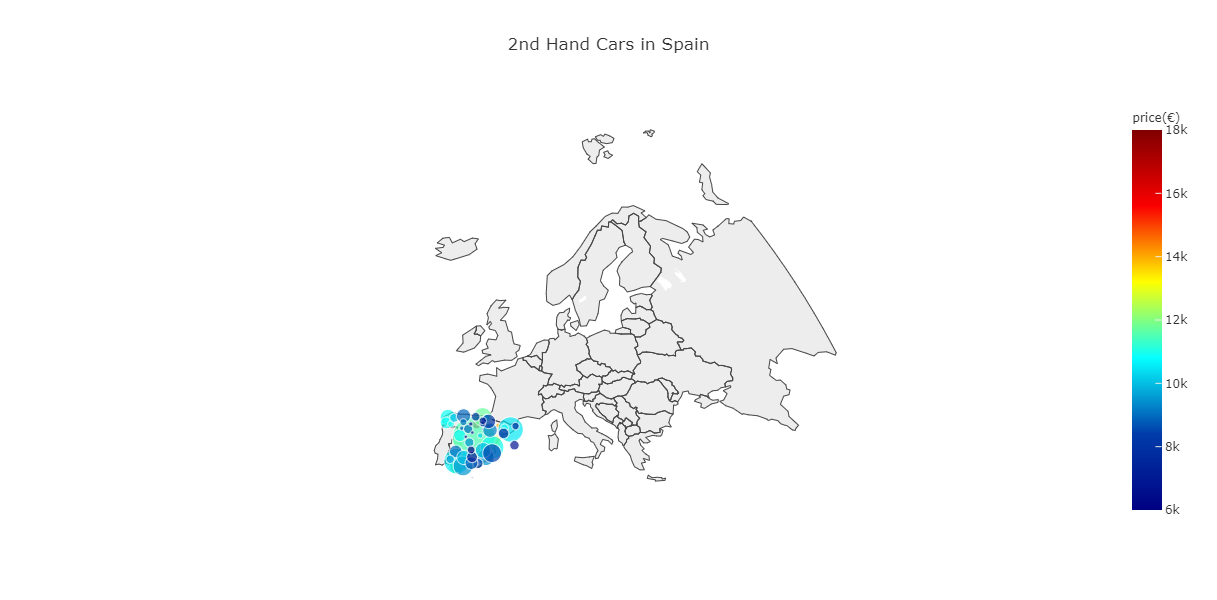

In [99]:
plot = px.scatter_geo(data_frame=df_map, 
                      title="2nd Hand Cars in Spain",
                      lat="latitud", 
                      lon="longitud", 
                      size="number_cars",
                      size_max=30,
                      text = "comunidad",
                      color = "price(€)",
                      color_continuous_scale="Jet",
                      range_color = (6000,18000),
                      hover_name = "region",
                     hover_data = ["price(€)","years_old", "horse_power", "population_region", 
                                   "percentage_professional", "adds_per_1000_people", "km", "km/year"],
                     projection = "aitoff",
                      scope = "europe",
                      width = 800,
                      height = 600,
                      template= "ggplot2"
                      #animation_frame = ["years_old"]
                     ) 
plot.show() 

From the plot above we can see that some interesting information. Some of the cheaper areas are:
   * Avila, Ciudad Real, Palencia (4000-5000€, ~12 years-old cars)
   * Segovia, Illes Balears,Alava, Jaen (7000€, ~11 years-old cars)
   * Tarragona, Girona, La Rioja, Cantabria, Las Palmas, Zamora, Navarra (7500€, ~10 years-old cars)
We can observe it seems to be a negative correlation between **price** and **years_old** car.

Lets explore the relactionships among these car features using a pair plot

In [19]:
df_map_pairs = df_map.drop(["latitud", "longitud"], axis=1)

In [20]:
df_map_pairs.head(2)

,comunidad,region,horse_power,km,km/year,population_region,number_cars,price(€),percentage_professional,years_old,adds_per_1000_people
9,Aragón,Teruel,150.0,36000.0,14535.7,146751,166.0,22900.0,93.4,3.0,1.1
50,Valencia,Castellon,125.5,61000.0,14511.8,602301,646.0,13150.0,86.5,4.0,1.1


In [21]:
df_map_pairs.sort_values(by="price(€)")

,comunidad,region,horse_power,km,km/year,population_region,number_cars,price(€),percentage_professional,years_old,adds_per_1000_people
34,Ceuta y Melilla,Melilla,163.0,125000.0,6900.0,73460,5.0,3700.0,40.0,18.0,0.1
33,Ceuta y Melilla,Ceuta,105.0,150000.0,15000.0,78674,3.0,3800.0,0.0,11.0,0.0
20,Castilla León,Avila,115.0,151000.0,15000.0,171680,52.0,3925.0,53.8,12.0,0.3
16,Castilla La Mancha,Ciudad real,125.0,182000.0,16923.1,527273,261.0,4790.0,69.7,12.0,0.5
23,Castilla León,Palencia,120.0,173500.0,14395.8,173306,80.0,5725.0,80.0,12.0,0.5
25,Castilla León,Segovia,140.0,160000.0,17450.0,164854,57.0,6800.0,75.4,11.0,0.3
41,Islas Baleares,Illes balears,110.0,113500.0,13000.0,1095426,406.0,6850.0,62.3,10.0,0.4
46,País Vasco,Alava,130.0,140000.0,14375.0,313819,243.0,6990.0,75.7,11.0,0.8
5,Andalucía,Jaen,120.0,145500.0,15165.2,669782,522.0,6999.5,73.4,10.5,0.8
32,Catalunya,Tarragona,125.0,104000.0,13899.0,803301,496.0,7445.0,78.6,10.0,0.6


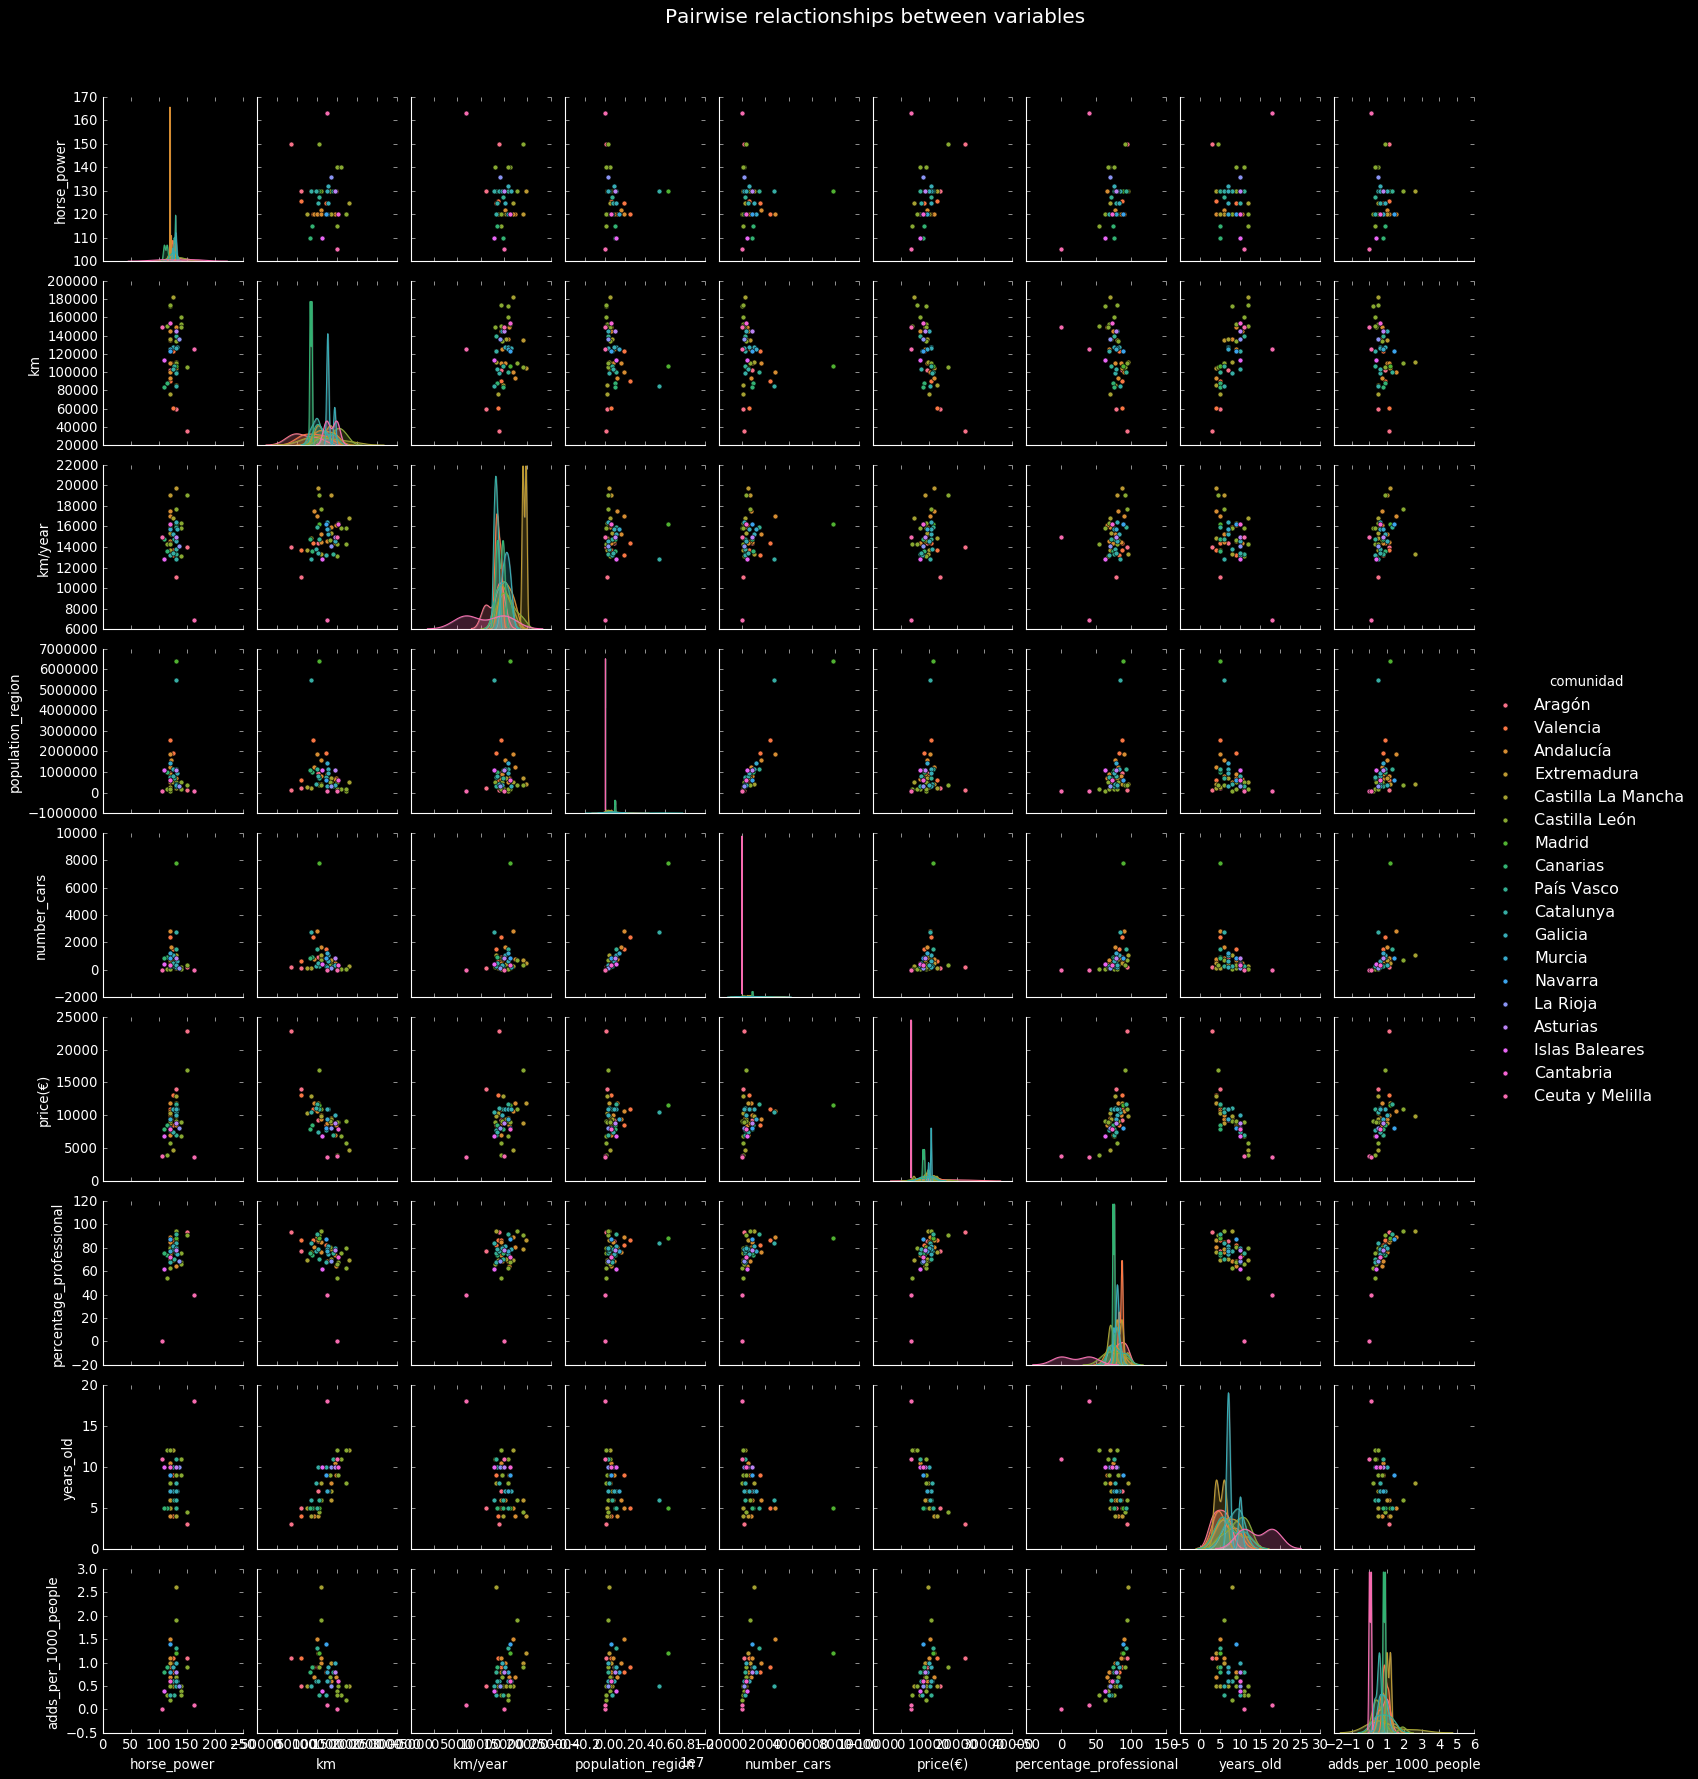

In [128]:
plt.style.use("dark_background")

g = sns.pairplot(data=df_map_pairs, height=2.5, hue="comunidad", aspect=0.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = g.fig  
fig.subplots_adjust(top=0.93, wspace=0.1)
t = fig.suptitle('Pairwise relactionships between variables', fontsize=18)
#fig.savefig("Figures/Pair_kde_cars.png", dpi=400, bbox_inches="tight")
plt.show()

* Price vs years_old -> Negative corr (Logically)
* Price vs km -> Negative corr (Logically)
* Price vs %_profesional -> Positive corr (Businesses charge more than particular owners)
* Price vs adds_per_people -> Positive corr 

* Adds_per_people vs %_profesional -> Positive Corr (More professionals - More adds - More price)

* Adds_per_people vs years_old car -> Negative corr

* Number_cars vs population -> Positive corr (Logically)
* Years_old vs km -> Positive corr (Logically)



Since we are particularly interested on the Features that **correlate well** with our target variable (**Price**), let's take a closer look to those relactionships using **Plotly**

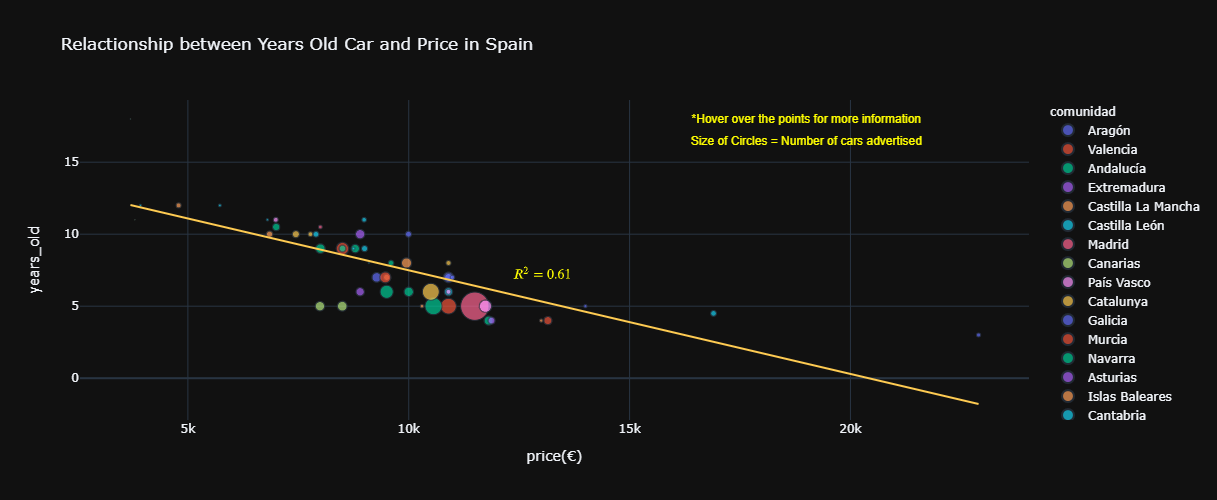

In [100]:

fig = px.scatter(df_map_pairs,
                 title="Relactionship between Years Old Car and Price in Spain",
                 x="price(€)", 
                 y="years_old", 
                 size="number_cars",
                 hover_name = "region",
                hover_data=["percentage_professional", "horse_power", "adds_per_1000_people"],
                color="comunidad",
                template="plotly_dark", 
                width=700, height=500)
fig.add_trace(go.Scatter(x=[19000, 19000, 13000], y=[17.5, 16, 7], 
                         mode="text", 
                         text=["*Hover over the points for more information",
                               "Size of Circles = Number of cars advertised", 
                               "$R^{2}=0.61$"],
                        textposition="top center",
                        textfont=dict(family="arial", size=12, color="yellow")))
 
help_fig = px.scatter(df_map_pairs, x="price(€)", y="years_old", trendline="ols")
x_trend = help_fig["data"][1]['x']
y_trend = help_fig["data"][1]['y']
fig.add_trace(go.Line(x=x_trend, y=y_trend))

fig.show()
# help_fig.show()

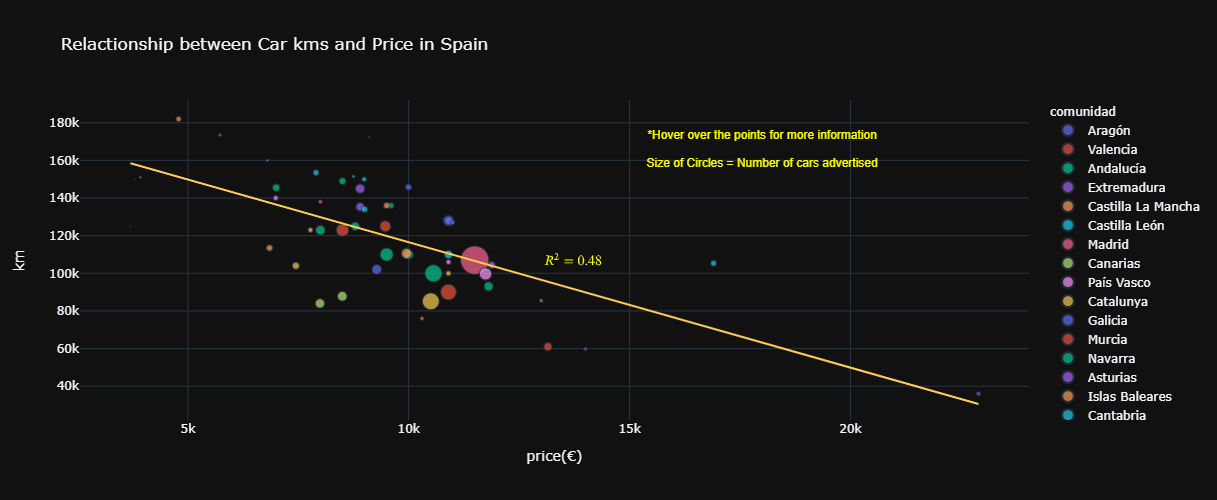

In [101]:
fig = px.scatter(df_map_pairs,
                 title="Relactionship between Car kms and Price in Spain",
                 x="price(€)", 
                 y="km", 
                 size="number_cars",
                 hover_name = "region",
                hover_data=["percentage_professional", "horse_power", "adds_per_1000_people"],
                color="comunidad",
                template="plotly_dark",
                width=700, height=500)
fig.add_trace(go.Scatter(x=[18000, 18000, 13700], y=[170000, 155000, 105000], 
                         mode="text", 
                         text=["*Hover over the points for more information",
                               "Size of Circles = Number of cars advertised",
                              "$R^{2}=0.48$"],
                        textposition="top center",
                        textfont=dict(family="arial", size=12, color="yellow")))

help_fig = px.scatter(df_map_pairs, x="price(€)", y="km", trendline="ols")
x_trend = help_fig["data"][1]['x']
y_trend = help_fig["data"][1]['y']
fig.add_trace(go.Line(x=x_trend, y=y_trend))
fig.show()
# help_fig.show()

Interestingly, the cheapest regions when looking at the price vs years_old and total_km are from the **canary irelands**.

**Zaragoza, Malaga and Tarragona** seem to be also good places to buy a car, with both years_old and km below most of the other regions.

The few cars advertised in Teruel seem to be quite new and consequently, expensive. Even the horse_power, and percentage professional is large in that region, indicating that there may be a business of **high-end cars**. We can later look at the actual brands to see f this is the case.



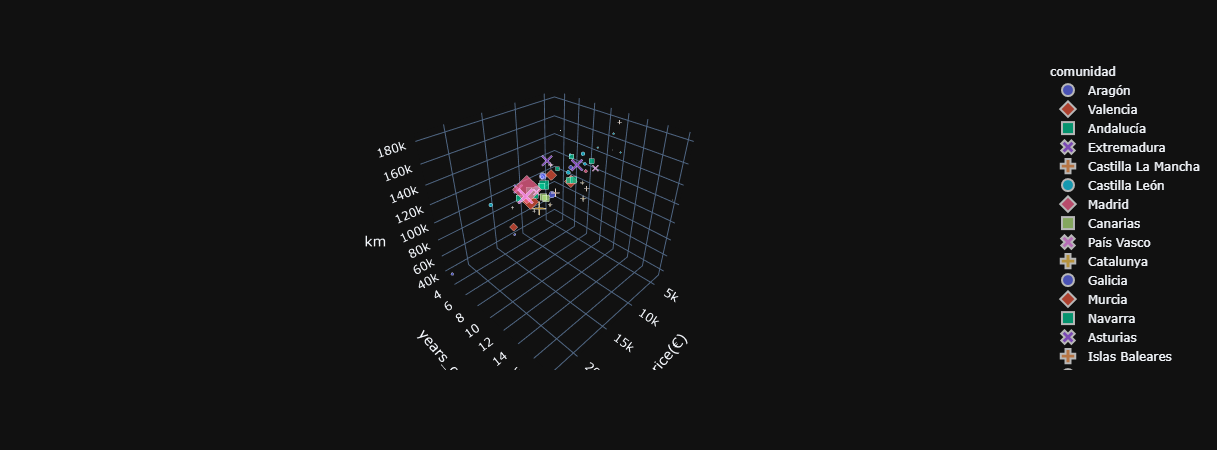

In [102]:
fig = px.scatter_3d(df_map_pairs, x="price(€)", y="years_old", z="km", 
                    color="comunidad", 
                    size="number_cars",
                    size_max =30,
                    hover_name="region",
                    hover_data=["percentage_professional", "horse_power", "adds_per_1000_people"],
                    symbol="comunidad",
                    template="plotly_dark"
                   ) 
fig.show()

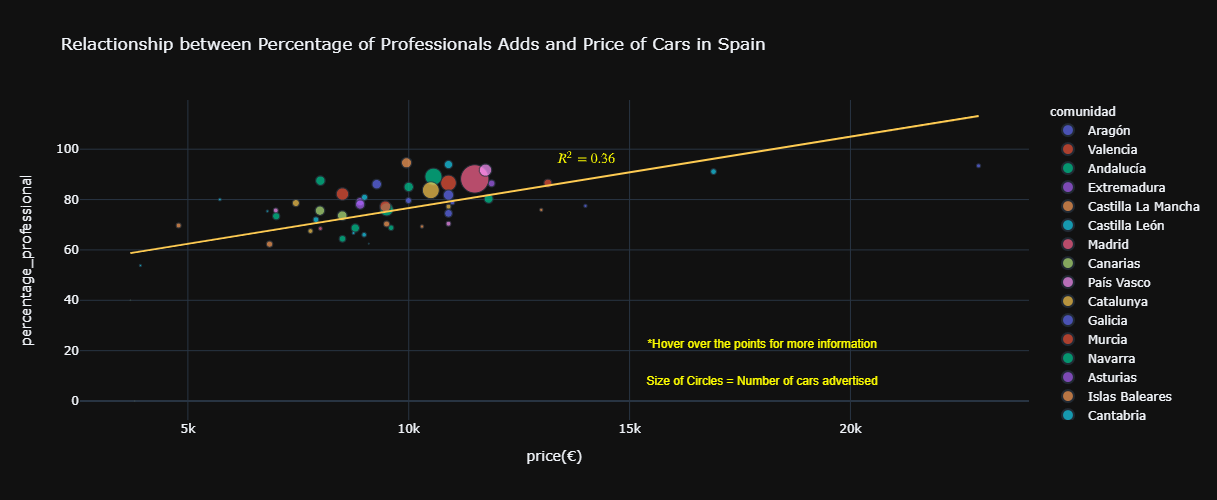

In [103]:
import plotly.express as px
fig = px.scatter(df_map_pairs, 
                 title="Relactionship between Percentage of Professionals Adds and Price of Cars in Spain",
                 x="price(€)", 
                 y="percentage_professional", 
                 size="number_cars",
                 hover_name="region",
                hover_data=["price(€)", "km", "years_old", "horse_power", "adds_per_1000_people"],
                color="comunidad",
                template="plotly_dark", 
                width=700, height=500)
fig.add_trace(go.Scatter(x=[18000, 18000,14000], y=[20, 5, 95], 
                         mode="text", 
                         text=["*Hover over the points for more information",
                               "Size of Circles = Number of cars advertised",
                              "$R^{2}=0.36$"],
                        textposition="top center",
                        textfont=dict(family="arial", size=12,color="yellow")))
help_fig = px.scatter(df_map_pairs, x="price(€)", y="percentage_professional", trendline="ols")
x_trend = help_fig["data"][1]['x']
y_trend = help_fig["data"][1]['y']
fig.add_trace(go.Line(x=x_trend, y=y_trend))

fig.show()
# help_fig.show()

### 3.2 Find the best deals

To find the best deals a good start would be to plot (as we did before above for the regions) the **price** *vs* the **year_old** and **km** of the car. This time however, we want to pay also attention to the **brand** and **specific model**.

#### 3.2.1) What brands have the best deals? And which are the most popular?

Lets use a pivot table to order the brands by average price of the advertised cars in our dataset.

In [29]:
df_brands = pd.pivot_table(data=df, index=["brand"], 
              values=["years_old", "price(€)", "horse_power", "seller_bool", "km", "km/year"],
              aggfunc = {"seller_bool": "mean", "km":"median", "km/year":"median",
                        "years_old": "median", "horse_power": "median", "price(€)": ["median", "count"]}).reset_index()

In [30]:
df_brands.columns

MultiIndex([(      'brand',       ''),
            ('horse_power', 'median'),
            (         'km', 'median'),
            (    'km/year', 'median'),
            (   'price(€)',  'count'),
            (   'price(€)', 'median'),
            ('seller_bool',   'mean'),
            (  'years_old', 'median')],
           )

In [31]:
df_brands.columns = ['brand', 'horse_power', 'km', 'km/year', 'number_cars', 'price(€)', 'percentage_professional', 'years_old']

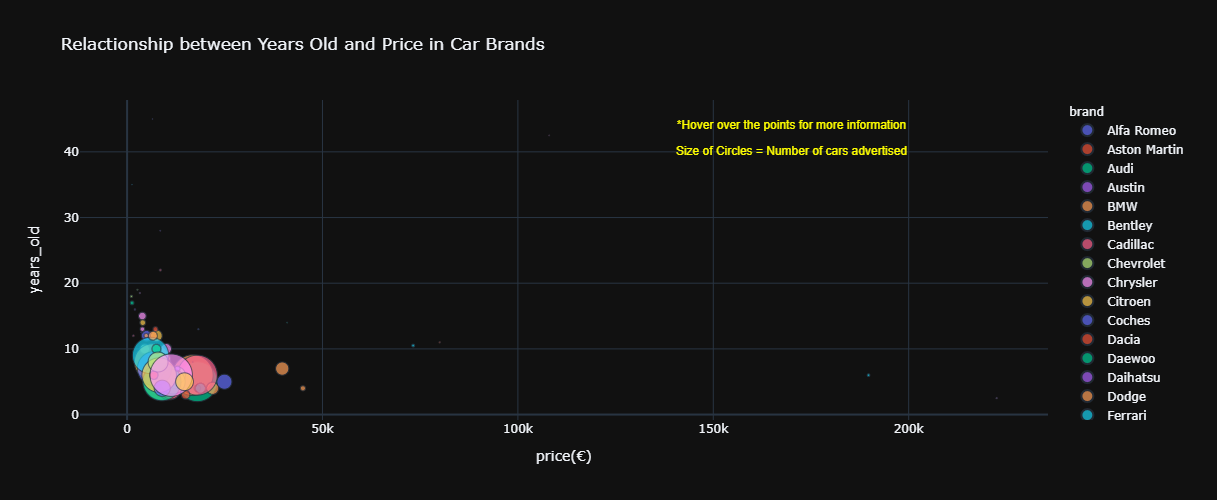

In [104]:
fig = px.scatter(df_brands,
                 title="Relactionship between Years Old and Price in Car Brands",
                 x="price(€)", 
                 y="years_old", 
                 size="number_cars",
                 size_max=30,
                 hover_name = "brand",
                hover_data=["percentage_professional", "horse_power", "km"],
                color="brand",
                template="plotly_dark",
                width=700, height=500)
fig.add_trace(go.Scatter(x=[170000, 170000], y=[43, 39], 
                         mode="text", 
                         text=["*Hover over the points for more information",
                               "Size of Circles = Number of cars advertised"],
                        textposition="top center",
                        textfont=dict(family="arial", size=12,color="yellow")))
fig.show()


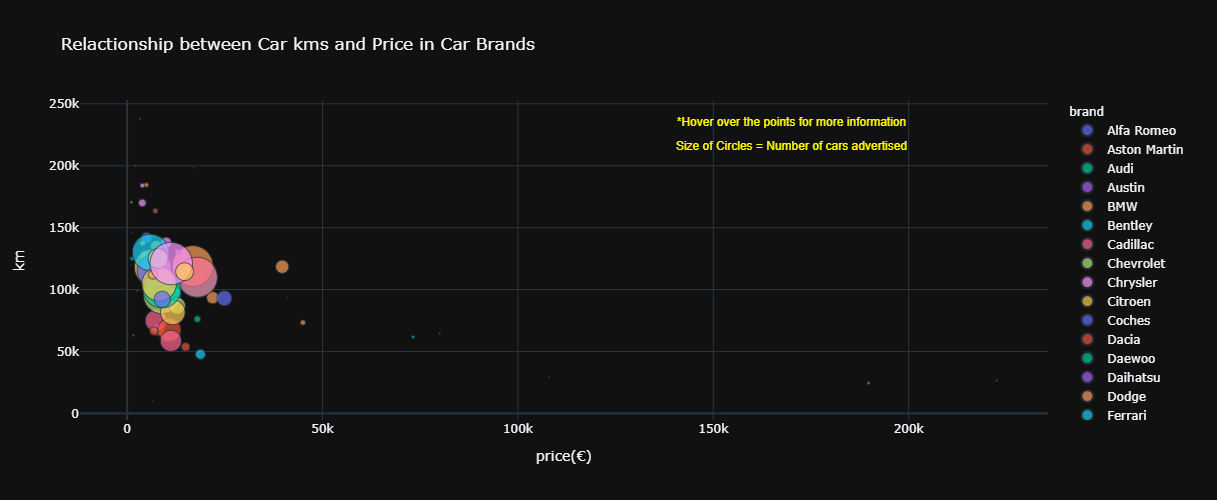

In [105]:
fig = px.scatter(df_brands,
                 title="Relactionship between Car kms and Price in Car Brands",
                 x="price(€)", 
                 y="km", 
                 size="number_cars",
                 size_max = 30,
                 hover_name = "brand",
                hover_data=["percentage_professional", "horse_power", "years_old"],
                color="brand",
                template="plotly_dark", 
                width=700, height=500)
fig.add_trace(go.Scatter(x=[170000, 170000], y=[230000, 210000], 
                         mode="text", 
                         text=["*Hover over the points for more information",
                               "Size of Circles = Number of cars advertised"],
                        textposition="top center",
                        textfont=dict(family="arial", size=12,color="yellow")))

fig.show()

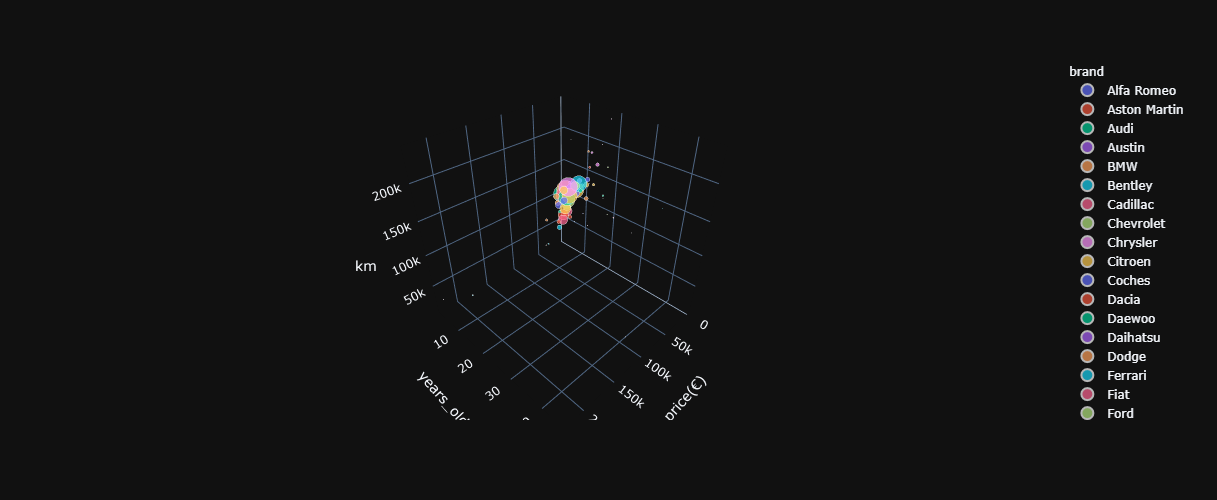

In [106]:
fig = px.scatter_3d(df_brands, x="price(€)", y="years_old", z="km", 
                    color="brand", 
                    size="number_cars",
                    size_max =30,
                    hover_name="brand",
                    hover_data=["percentage_professional", "horse_power"],
                    template="plotly_dark",
                    width=700, height=500
                   ) 
fig.show()

Observations regarding the car brands:
   * **Fiat** price is quite low (7000eur) considering their average low years of use (5) and low km (76000).
   * Some other interesting brands are **Kia**,  **Hunday** and **Nissan**.

   * Also, we can observe that the most popular brands are **Volkswagen**(3600 units), **Audi**(3200 units), **BMW**(3300 units), **Renault** and **Ford**(2700 units each)

#### 3.2.2) What models contain the best offers? which are the most reliable?:

In [35]:
df_models = pd.pivot_table(data=df, index=["model", "brand", "brand_class"], 
              values=["years_old", "price(€)", "horse_power", "seller_bool", "km", "km/year"],
              aggfunc = {"seller_bool": "mean", "km":"median", "km/year":"median",
                        "years_old": "median", "horse_power": "median", "price(€)": ["median", "count"]}).reset_index()

In [36]:
df_models.columns

MultiIndex([(      'model',       ''),
            (      'brand',       ''),
            ('brand_class',       ''),
            ('horse_power', 'median'),
            (         'km', 'median'),
            (    'km/year', 'median'),
            (   'price(€)',  'count'),
            (   'price(€)', 'median'),
            ('seller_bool',   'mean'),
            (  'years_old', 'median')],
           )

In [37]:
df_models.columns = ['model', 'brand', 'brand_class', 'horse_power', 'km', 'km/year', 'number_cars', 'price(€)', 'percentage_professional', 'years_old']

In [38]:
df_models_lim = df_models.loc[(df_models["km"] < 400000)&(df_models["price(€)"] < 40000)&(df_models["years_old"] < 20)]

In [39]:
df_models_lim.columns

Index(['model', 'brand', 'brand_class', 'horse_power', 'km', 'km/year',
       'number_cars', 'price(€)', 'percentage_professional', 'years_old'],
      dtype='object')

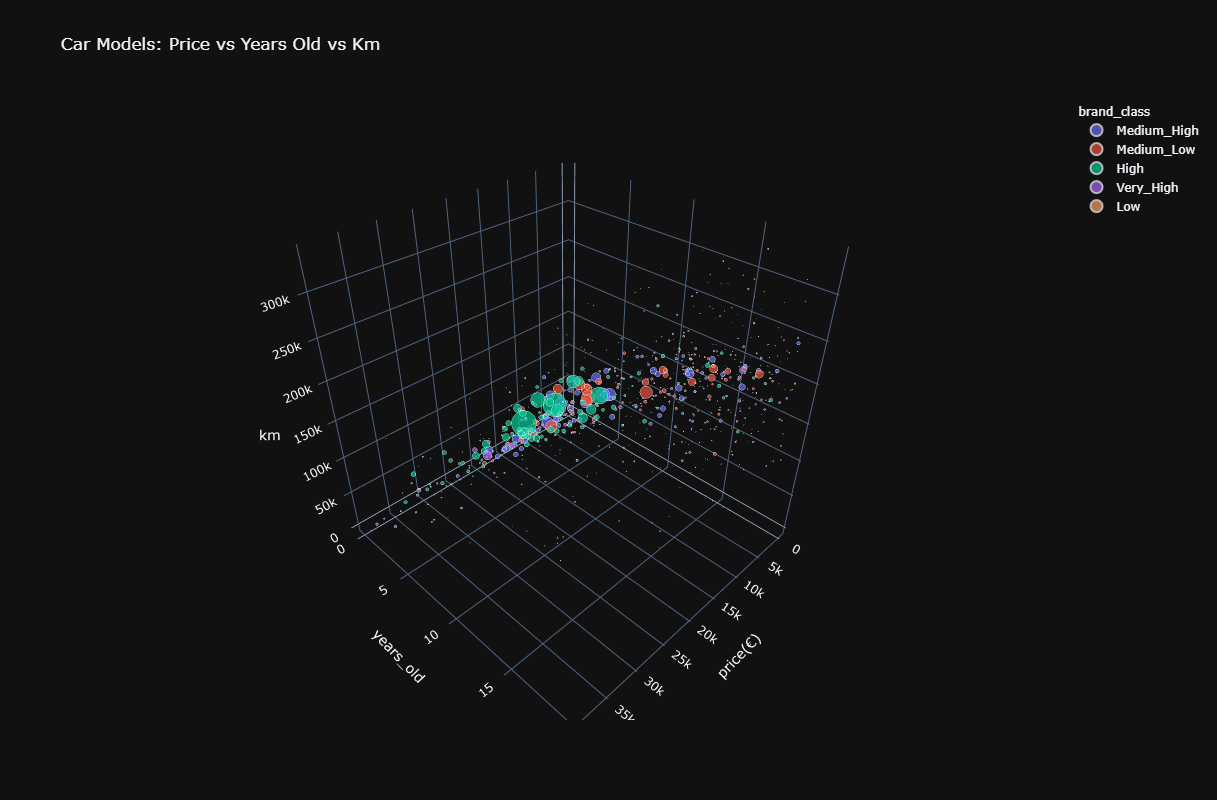

In [107]:
fig = px.scatter_3d(df_models_lim, x="price(€)", y="years_old", z="km", 
                    title="Car Models: Price vs Years Old vs Km",
                    color="brand_class", 
                    size="number_cars",
                    size_max =40,
                    hover_name="model",
                    hover_data=["percentage_professional", "horse_power"],
                    template="plotly_dark", width=800, height=800)
                   
fig.show()

Based on the above plots, regarding the most economical models I would highlight:
* **CitroenC3, Citroen Celysee, Opel Corsa**
* **Fiat Typo**
* **Kia Ceed, Kia Picanto**
    

In [41]:
df_models_reliable = df_models.loc[(df_models["km"] > 200000)&(df_models["years_old"] > 20)]

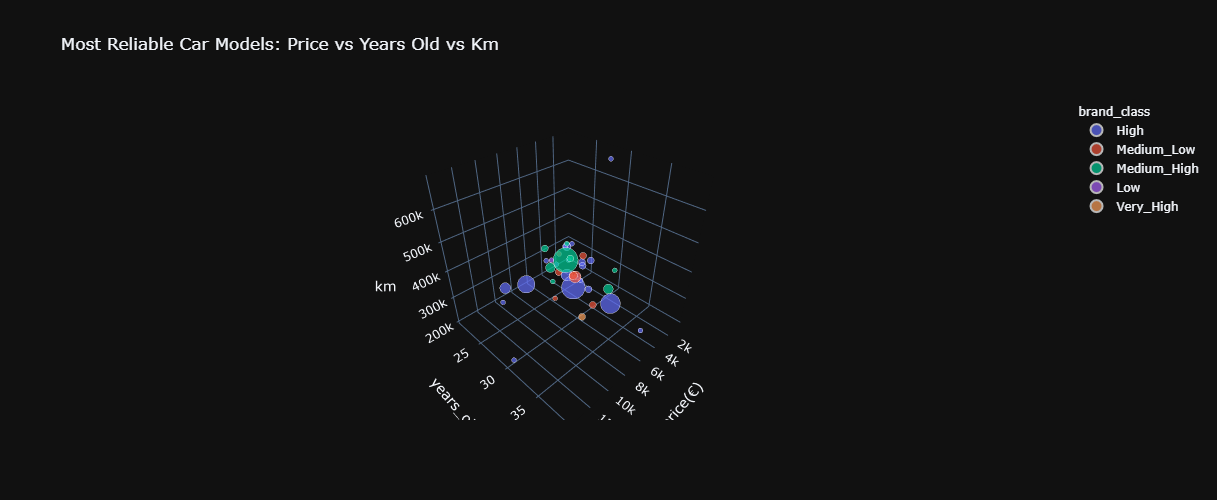

In [108]:
fig = px.scatter_3d(df_models_reliable, x="price(€)", y="years_old", z="km", 
                    title="Most Reliable Car Models: Price vs Years Old vs Km",
                    color="brand_class", 
                    size="number_cars",
                    size_max =40,
                    hover_name="model",
                    hover_data=["percentage_professional", "horse_power"],
                    template="plotly_dark", width=700, height=500)
                
fig.show()

**Mercedes Benz** Models 190 and 300, **Peugot 306** and **Nissan Patrol** are the ones with the highest number of vehicles advertised among the oldest. This means that they seem to be reliable models. Nonetheless, to get a better idea about this aspect we should have to take in account the **popularity** of these cars. For instance, instead of using the cars advertised, we could use number of cars advertised, divided by the total amount of models sold.

#### 3.2.3) What are the best deals overall? 🤔

**Suposing we want to find the cheapers cars (<3000eur) that are not too old (less than 15 years) and not too used (< 200 km):**

In [43]:
df_cheap = df.loc[(df["price(€)"]<3000)&(df["years_old"] <= 15)&(df["km"]<= 200000)]

In [44]:
df_cheap["seller_bool"].value_counts()

1    847
0    414
Name: seller_bool, dtype: int64

In [45]:
df.columns

Index(['title', 'link', 'km', 'year', 'gear', 'doors', 'horse_power',
       'price(€)', 'fuel', 'seller', 'full_description', 'date_advertised',
       'description_len', 'brand', 'region', 'model',
       'technical_service_mentioned', 'years_old', 'comunidad',
       'population_region', 'latitud', 'longitud', 'seller_bool', 'fuel_bool',
       'gear_bool', 'km/year', 'brand_class', 'price_class'],
      dtype='object')

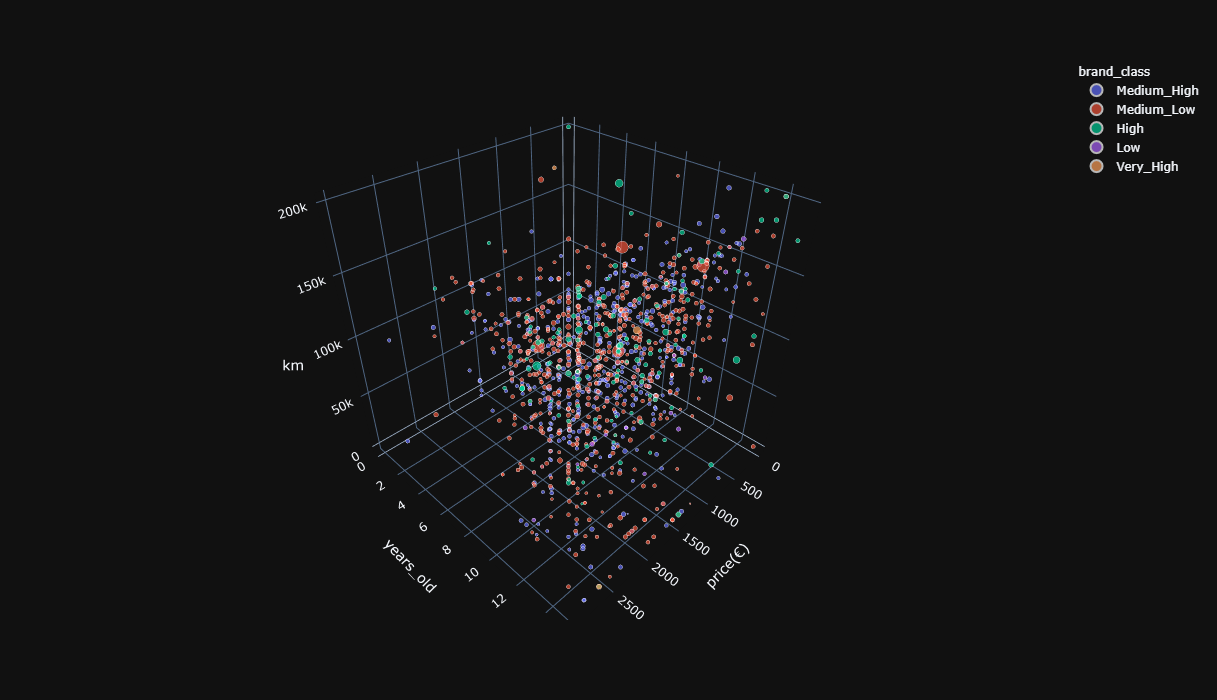

In [109]:
fig = px.scatter_3d(df_cheap, x="price(€)", y="years_old", z="km", 
                    color="brand_class", 
                    size="horse_power",
                    size_max =20,
                    hover_name="title",
                    hover_data=[df_cheap.index, "region", "seller", "horse_power", "doors",
                               "technical_service_mentioned", "fuel", "date_advertised"],
                    template="plotly_dark", width=800, height=700)
                   
fig.show()

Say that we are looking for some nice 5 door deals. Using the plot above we can quickly locate 5 promising cars. Let's check them out!

In [151]:
df.loc[7139].link 

'https://www.milanuncios.com/renault-de-segunda-mano/renault-trafic-365630644.htm'

Note: If the car does not longer display, the add may have been removed.

[Car 1](https://www.milanuncios.com/suzuki-de-segunda-mano/suzuki-alto-367774787.htm)

[Car 2](https://www.milanuncios.com/nissan-de-segunda-mano/nissan-micra-368395331.htm)

[Car 3](https://www.milanuncios.com/tata-de-segunda-mano/tata-indica-ano-2008-368041173.htm)

[Car 4](https://www.milanuncios.com/fiat-de-segunda-mano/fiat-panda-357650587.htm)

In [51]:
best_deals = df_cheap.sort_values(by=["price(€)", "years_old", "km", "doors"])

### 3.3 Feature selection for modeling

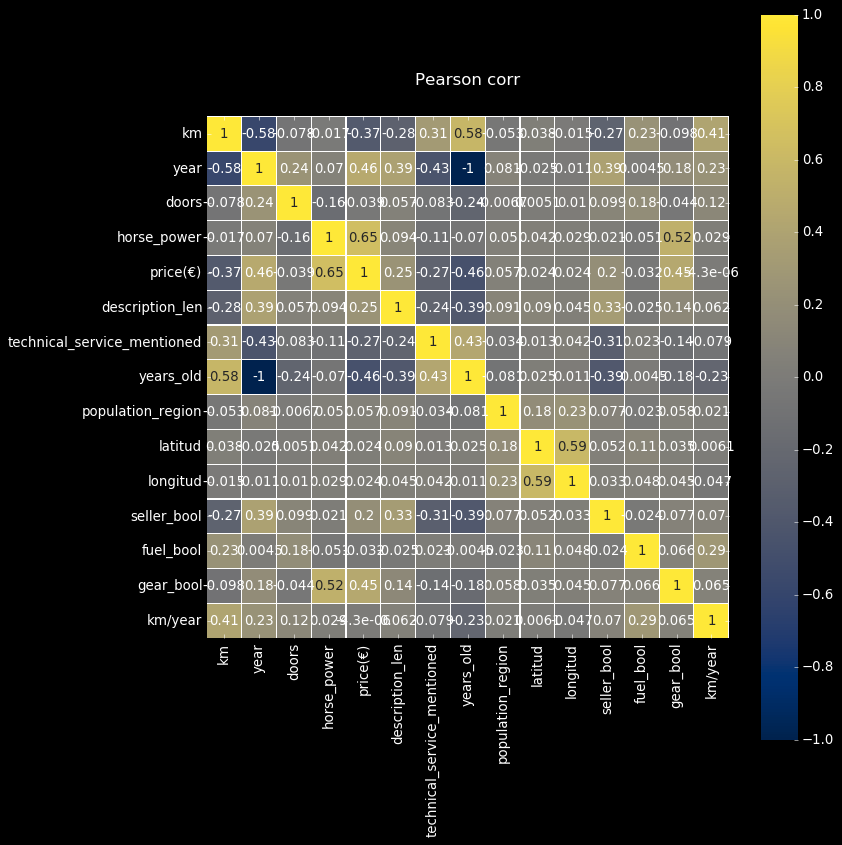

In [153]:

plt.rcParams["figure.figsize"] = (11,11)
colormap=plt.cm.cividis
plt.title("Pearson corr", y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)
plt.tight_layout()
# plt.savefig("Figures/corr_cars.png", dpi=400, bbox_inches="tight")
plt.show()

In [154]:
corr_matrix = df.corr()

In [155]:
feat_price_corr = abs(corr_matrix[["price(€)"]]).sort_values(by="price(€)", ascending=False)[1:]

In [156]:
feat_price_corr

,price(€)
horse_power,0.650418
years_old,0.463053
year,0.463053
gear_bool,0.451151
km,0.369912
technical_service_mentioned,0.265462
description_len,0.246724
seller_bool,0.197335
population_region,0.056917
doors,0.038871


In [157]:
df.columns

Index(['title', 'link', 'km', 'year', 'gear', 'doors', 'horse_power',
       'price(€)', 'fuel', 'seller', 'full_description', 'date_advertised',
       'description_len', 'brand', 'region', 'model',
       'technical_service_mentioned', 'years_old', 'comunidad',
       'population_region', 'latitud', 'longitud', 'seller_bool', 'fuel_bool',
       'gear_bool', 'km/year', 'brand_class', 'price_class'],
      dtype='object')

In [158]:
len(df.brand.unique())

60

Let's select some of the highest corr numerical features.

As for the categorical features we have seen that location, model and brand play a role in the car's price

In [52]:
df_model = df[["horse_power", "years_old", "km", "doors", "description_len", "gear_bool", "seller_bool", "fuel_bool", "region", "brand", "price(€)"]]

In [53]:
df_model = pd.get_dummies(df_model)

In [54]:
df_model.columns = df_model.columns.str.replace("region_", "")
df_model.columns = df_model.columns.str.replace("brand_", "")

In [55]:
df_model

,horse_power,years_old,km,doors,description_len,gear_bool,seller_bool,fuel_bool,price(€),a coruña,...,Skoda,Smart,Ssangyong,Subaru,Suzuki,Talbot,Tata,Toyota,Volkswagen,Volvo
0,105.0,15,158000,5,339,0,1,1,3999,0,...,1,0,0,0,0,0,0,0,0,0
1,333.0,6,69900,2,1049,1,1,0,25990,0,...,0,0,0,0,0,0,0,0,0,0
2,177.0,0,8000,5,867,1,1,1,53890,0,...,0,0,0,0,0,0,0,1,0,0
3,184.0,5,48100,4,930,1,1,1,22850,0,...,0,0,0,0,0,0,0,0,0,0
4,143.0,7,167000,5,283,0,1,1,17900,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40210,90.0,8,141000,3,468,0,1,1,7950,0,...,0,0,0,0,0,0,0,0,1,0
40211,120.0,4,86000,5,603,0,1,1,10500,0,...,0,0,0,0,0,0,0,0,0,0
40212,65.0,17,186000,5,118,0,1,1,2200,1,...,0,0,0,0,0,0,0,0,0,0
40213,120.0,2,20304,5,1036,0,1,1,16690,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_model.to_csv("Data\\df_model.csv")

In [48]:
df_model = pd.read_csv("Data\\df_model.csv")
df_model = df_model.drop("Unnamed: 0", axis=1)

## 4. Data Split

We want that after our split, we obtain a balanced distribution of the target values accorss the data. Hence, we first need to see whether if our target **normaly distributed** or **skewed**? We will start predicting the Total Usage. We observe that the data is skewed to the right. Hence, stratifying the data set is adviced for the splitting.

Since it has been observed that the horse_power feature is important. We will want our test set to be representative of the various categories of horse_power in the whole dataset.

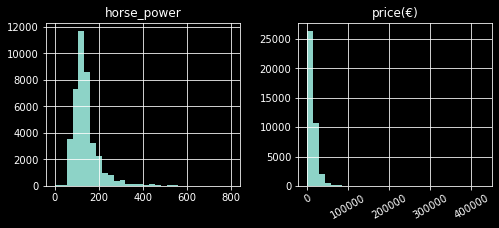

In [49]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,3)
df_model[["price(€)", "horse_power"]].hist(bins=30)
plt.xticks(rotation=30)
plt.show()

In [50]:
def strater (item):
    if item <= 80:
        return 1
    elif item > 80 and item <= 105:
        return 2
    elif item > 105 and item <= 145:
        return 3
    elif item > 145 and item <= 190:
        return 4
    else:
        return 5

In [51]:
df_model["strat"] = df_model["horse_power"].apply(strater)

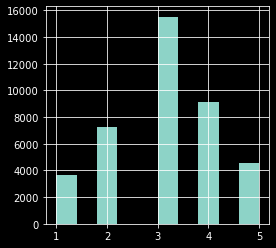

In [52]:
plt.rcParams["figure.figsize"] = (4,4)
df_model["strat"].hist(bins=10)
plt.show()

In [53]:
X = df_model.drop(["price(€)"], axis=1)
y = df_model["price(€)"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [54]:
test_set = X_test

In [55]:
test_set["strat"] = X_test["horse_power"].apply(strater)

In [56]:
split = StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state=42)

In [57]:
for train_index, test_index in split.split(df_model, df_model["strat"]):
    strat_train_set = df_model.loc[train_index]
    strat_test_set = df_model.loc[test_index]

In [58]:
def proportions(data):
    return data["strat"].value_counts()/len(data)

In [59]:
comparing = pd.DataFrame({"Overall": proportions(df_model),
                         "Stratified": proportions(strat_test_set),
                         "Random": proportions(X_test)}).sort_index()

In [60]:
comparing = round(comparing *100,2) 

In [61]:
comparing

,Overall,Stratified,Random
1,9.14,9.14,9.00
2,18.09,18.09,18.66
3,38.59,38.59,38.48
4,22.79,22.79,22.33
5,11.40,11.39,11.53


**Comparing**:

We can observe how the proportions in the stratified set are closer 
to those in the whole set compared to the ramdomly generated set

In [62]:
strat_train_set.drop("strat", axis=1, inplace=True)
strat_test_set.drop("strat", axis=1, inplace=True)

In [63]:
X_train = strat_train_set.drop(["price(€)"], axis=1)
y_train = strat_train_set["price(€)"].values

In [64]:
X_test = strat_test_set.drop(["price(€)"], axis=1)
y_test = strat_test_set["price(€)"].values

In [65]:
df_model.drop("strat", axis=1, inplace=True)
X.drop("strat", axis=1, inplace=True)

## 5. Data preprocessing

Since our data variables have sparce scales (i.e. km and horse power), we should Standarize the data. I will be using the **StandardScaler()** Sklearn method for this.

In [66]:
 # Scaling all the the data
scaler = StandardScaler().fit(X)
X_rescaled = scaler.transform(X)

In [67]:
df_rescaled=pd.DataFrame(X_rescaled)
df_rescaled.columns = X.columns

Lets use some PCA to observe what components are driving the variance in our train set

In [68]:
# PCA
pca = PCA(n_components = 3)
X3D = pca.fit_transform(X_rescaled)

In [69]:
sum(pca.explained_variance_ratio_) # Three components only account for 5% of the variance!

0.05074938453341015

In [70]:
X_red = pd.DataFrame(X3D)

In [71]:


week_day_pca = pd.concat([X_red,pd.DataFrame(df["brand_class"], columns=["brand_class"])], axis=1)
week_day_pca.columns = ["Component1", "Component2", "Component3", "brand_class"]

fig = px.scatter_3d(week_day_pca, x='Component1', y='Component2', z='Component3',
              color='brand_class', template = "plotly_dark", width=700, height=500)

fig.show()

Standarize train and test sets. Not need to standarize binary(dummy) variables though.

In [72]:
scaler_train= StandardScaler().fit(X_train.iloc[:,:5]) # not dummy variables

X_train_nodummy = scaler_train.transform(X_train.iloc[:,:5])
X_test_nodummy = scaler_train.transform(X_test.iloc[:,:5])

In [73]:
X_train = np.concatenate((X_train_nodummy,X_train.iloc[:,5:]), axis=1)
X_test = np.concatenate((X_test_nodummy,X_test.iloc[:,5:]), axis=1)

In [74]:
X_test.shape

(8043, 120)

In [75]:
hist_df = pd.DataFrame(X_train).iloc[:,:5]

In [76]:
hist_df.columns = X.columns[:5]

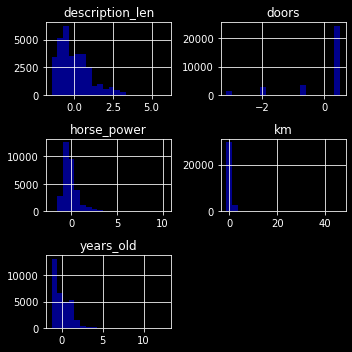

In [77]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (5,5)
hist_df.hist(bins=20, color="darkblue")
plt.xticks(fontsize=8, color = "k")
plt.tight_layout()
#plt.savefig("Figures/hist_features_cars.png", dpi=400, bbox_inches="tight")
plt.show()

### 6. Exploring model performance

In [121]:
SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
 'neg_mean_poisson_deviance': make_scorer(mean_poisson_deviance, greater_is_better=False),
 'neg_mean_gamma_deviance': make_scorer(mean_gamma_deviance, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
 'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr),
 'roc_auc_ovo': make_sc

In [ ]:
# Exploring model performance. Metrics used neg_mean_squared_error using cross-validation

models = []

models.append(('Lasso', Lasso())) 
models.append(('EN', ElasticNet()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('SVR', SVR())) 
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor())) 
models.append(('ETR', ExtraTreesRegressor()))

xgbr_params = {'objective':'reg:squarederror'}
models.append(('XGB', xgb.XGBRegressor(**xgbr_params)))

results_model = []
names_model = []
run_time = []
for name, model in models:
    KF = KFold(n_splits=10, random_state=42)
    start = dt.datetime.now()
    cv_results = cross_val_score(model, X_train, y_train, cv=KF, scoring='neg_mean_squared_error')
    results_model.append(cv_results)
    names_model.append(name)
    end  = dt.datetime.now() 
    duration = (end-start).seconds
    run_time.append(duration)
    msg = "%s: %s (%s) Running time: %s sec" % (name, round(cv_results.mean()), round(cv_results.std()), duration)
    print(msg)

In [159]:
run_sec = []
for i in run_time:
    s = str(i)+"s"
    run_sec.append(s)

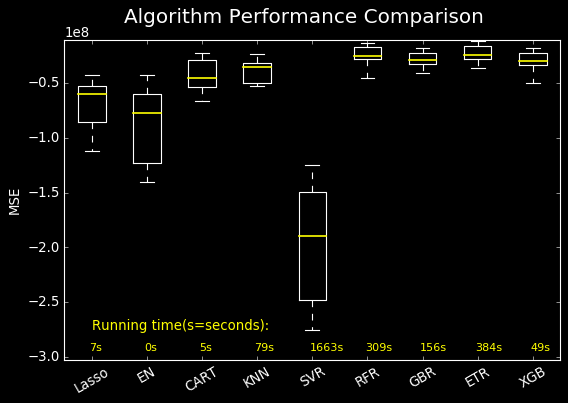

In [160]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,5)
fig = plt.figure()
fig.suptitle('Algorithm Performance Comparison', fontsize=18)

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

plt.boxplot(results_model, 
            boxprops=boxprops,
            medianprops=medianprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            showfliers=True, 
            flierprops=flierprops)

x_values = list(range(1,len(run_sec)+1))
y_max = pd.DataFrame(results_model).max().max()
y_min = pd.DataFrame(results_model).min().min()

plt.text(s="Running time(s=seconds):", x = 1., y = y_min, color="yellow") 
plt.ylim(y_min + 0.1*y_min, y_max - 0.1*y_max)
for i in range(len(x_values)):
    plt.text(s=run_sec[i], x = x_values[i]-0.05, y = y_min + 0.07*y_min, color="yellow", fontsize=10)  

ax = fig.add_subplot(111)
ax.set_xticklabels(names_model, rotation=30)
ax.set_ylabel("MSE")

plt.savefig("Figures\\algo_comparisson_cars.png", dpi=400, bbox_inches="tight")

plt.show()

The above analysis revealed **Extreme Tree Regressor(ETR)** as the most promissing model. Lets fine tune it using GridSearchCV.

## 7. Fine Tunning and model evaluation

In [586]:
# GridSearchCV
n_estimators = [25, 60, 100, 120] 
#max_depth = [4, 8, 10]
#min_samples_leaf = [2, 5, 11]

#param_grid = dict(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth)

param_grid = dict(n_estimators=n_estimators)

model = ExtraTreesRegressor()
KF = KFold(n_splits=5, random_state=10) 
grid = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s"
      % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # Best -1237.545910 using {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 50}

Best: -22733741.305414 using {'n_estimators': 60}
-23739022.279958 (6923148.415463) with: {'n_estimators': 25}
-22733741.305414 (5870116.832940) with: {'n_estimators': 60}
-22879059.507254 (6121262.954543) with: {'n_estimators': 100}
-23625940.151615 (6920851.243402) with: {'n_estimators': 120}


In [78]:
EtReg = ExtraTreesRegressor(n_estimators=100, max_depth=16, min_samples_leaf=4, min_samples_split=2) # 
EtReg.fit(X_train,y_train) # 100, 16, 4, 2

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=16, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=4,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [79]:
score_train_EtReg = round(EtReg.score(X_train,y_train),2) # 0.92965

In [80]:
score_train_EtReg

0.93

In [81]:
score_test_EtReg = round(EtReg.score(X_test,y_test),2) # 0.92443

In [82]:
score_test_EtReg

0.93

In [83]:
y_pred = EtReg.predict(X_test)
y_pred= y_pred.reshape(-1,1)

In [84]:
metrics.mean_squared_error(y_test, y_pred)

12553923.111659098

In [85]:
metrics.mean_absolute_error(y_test, y_pred)

1915.240647927577

I will now create a scatter plot including the test and the predicted data.

In [86]:
(y_test.reshape(-1,1)).shape

(8043, 1)

In [87]:
y_pred.shape

(8043, 1)

In [88]:
df_scatter = pd.DataFrame(np.concatenate((y_test.reshape(-1,1), y_pred), axis=1), columns=["y_test", "y_pred"])

In [89]:
df_scatter = df_scatter.set_index(test_index)

In [90]:
fig = px.scatter(df_scatter,
                x="y_test", 
                y="y_pred",
                hover_name=df_scatter.index,
                hover_data=[df_scatter.index],
                template="plotly_dark", width=700, height=500)
fig.add_trace(go.Line(x=[0,300000], y=[0,300000], name="Perfect Prediction"))
fig.show()

Cars above the line have prices overestimated by the model, hence they maybe good deals, while the dots below the line represent prices understimated by the model (not good deals).

**Feature importance**

In [95]:
feat_imp = pd.Series(EtReg.feature_importances_)
features = pd.Series(X.columns)

In [107]:
feature_importance = pd.concat([features,feat_imp], axis=1, keys=["Feature","Importance"])

In [108]:
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

In [109]:
cumulative_importance_other = feature_importance[13:]["Importance"].sum()

In [110]:
rest_of_features = pd.DataFrame(["rest_of_features(107)", cumulative_importance_other])

In [111]:
rest_of_features = rest_of_features.T

In [112]:
rest_of_features.columns = ["Feature", "Importance"]

In [113]:
thirteen_top_features = feature_importance[:13]

In [114]:
feature_importance = pd.concat((thirteen_top_features, rest_of_features), axis=0).reset_index(drop=True)

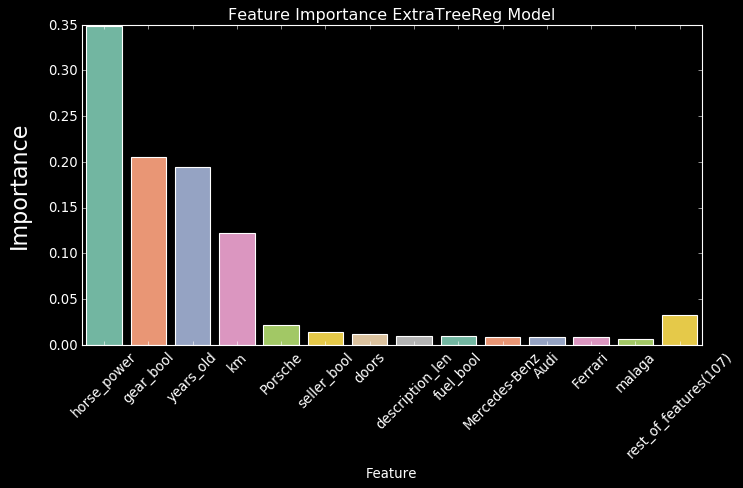

In [115]:
plt.rcParams["figure.figsize"] = (10,5)
imp_pallete = sns.color_palette("Set2")
sns.barplot(x="Feature", y="Importance", data=feature_importance, palette=imp_pallete)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel("Importance", labelpad=15, fontsize=20)
plt.title("Feature Importance ExtraTreeReg Model")
#plt.savefig("Figures/Feature_importance_cars.png", dpi=400, bbox_inches="tight")
plt.show()

Most of the dummy variables do not contribute significantly to the algo performace. Maybe we could speed up the algo removing them with out much cost on performance. **We can test this**.

In [116]:
X.columns[:13]

Index(['horse_power', 'years_old', 'km', 'doors', 'description_len',
       'gear_bool', 'seller_bool', 'fuel_bool', 'a coruña', 'alava',
       'albacete', 'alicante', 'almeria'],
      dtype='object')

In [313]:
df_train = pd.DataFrame(X_train)

In [314]:
df_train.columns = X.columns

In [315]:
df_train2 = df_train[["horse_power", "gear_bool", "years_old", "km", "Porsche",  "seller_bool", "doors", "description_len", "fuel_bool", "Mercedes-Benz", "Audi", "Ferrari", "malaga"]]

In [316]:
X_train2 = np.array(df_train2)

In [317]:
df_test = pd.DataFrame(X_test)

In [318]:
df_test.columns = X.columns

In [319]:
df_test2 = df_test[["horse_power", "gear_bool", "years_old", "km", "Porsche",  "seller_bool", "doors", "description_len", "fuel_bool", "Mercedes-Benz", "Audi", "Ferrari", "malaga"]]

In [320]:
X_test2 = np.array(df_test2)

In [125]:
# Exploring model performance. 
# This time I will test the best performing models based on the previous results

models2 = []

models2.append(('RFR', RandomForestRegressor()))
models2.append(('GBR', GradientBoostingRegressor())) 
models2.append(('ETR', ExtraTreesRegressor()))
xgbr_params = {'objective':'reg:squarederror'}
models2.append(('XGB', xgb.XGBRegressor(**xgbr_params)))

results_model2 = []
names_model2 = []
run_time2 = []
for name2, model in models2:
    KF = KFold(n_splits=10, random_state=42)
    start2 = dt.datetime.now()
    cv_results2 = cross_val_score(model, X_train2, y_train, cv=KF, scoring='neg_mean_squared_error')
    results_model2.append(cv_results2)
    names_model2.append(name2)
    end2  = dt.datetime.now() 
    duration2 = (end2-start2).seconds
    run_time2.append(duration2)
    msg2 = "%s: %s (%s) Running time: %s sec" % (name2, round(cv_results2.mean()), round(cv_results2.std()), duration2)
    print(msg2)

RFR: -26481541.0 (8887575.0) Running time: 113 sec
GBR: -30211480.0 (7791775.0) Running time: 29 sec
ETR: -25209663.0 (7831071.0) Running time: 70 sec
XGB: -31188778.0 (9818892.0) Running time: 10 sec


In [126]:
run_sec2 = []
for i in run_time2:
    s = str(i)+"s"
    run_sec2.append(s)

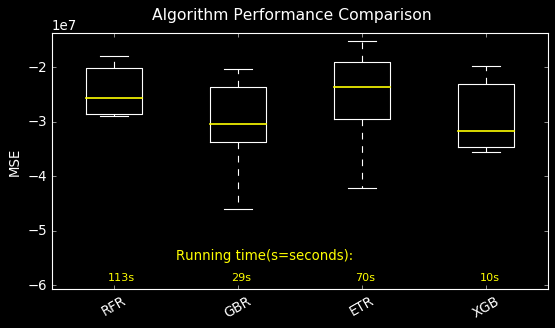

In [154]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (8,4)
fig = plt.figure()
fig.suptitle('Algorithm Performance Comparison', fontsize=14)

boxprops = dict(color="white",linewidth=1)
medianprops = dict(color="yellow",linewidth=1.5)
whiskerprops = dict(color="white",linewidth=1)
capprops = dict(color="white",linewidth=1)
flierprops = dict(color="yellow",linewidth=1)

x_values = list(range(1,len(run_time2)+1))
y_max = pd.DataFrame(results_model2).max().max()
y_min = pd.DataFrame(results_model2).min().min()

plt.boxplot(results_model2, 
            boxprops=boxprops,
            medianprops=medianprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            showfliers=True, 
            flierprops=flierprops)

plt.text(s="Running time(s=seconds):", x = 1.5, y = y_min, color="yellow") 
plt.ylim(y_min + 0.1*y_min, y_max - 0.1*y_max)
for i in range(len(x_values)):
    plt.text(s=run_sec2[i], x = x_values[i]-0.05, y = y_min + 0.07*y_min, color="yellow", fontsize=10)    

ax = fig.add_subplot(111)
ax.set_xticklabels(names_model2, rotation=30)
ax.set_ylabel("MSE")

#plt.savefig("Figures\\algo_performance_car2.png", dpi=300, bbox_inches="tight")
plt.show()

We can see how **Extreme Tree Regressor(ETR)** is still the best performing and we **reduced the running time from 366s to 55s**. Let's fine tune it and check if it is still performing as good as before.

In [612]:
# GridSearchCV
n_estimators = [100] 
max_depth = [10,12,14]
min_samples_leaf = [3, 5]

param_grid = dict(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_depth=max_depth)

model = ExtraTreesRegressor()
KF = KFold(n_splits=5, random_state=10) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=KF)
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -26875181.996996 using {'max_depth': 14, 'min_samples_leaf': 3, 'n_estimators': 100}
-29886828.745865 (7798892.978341) with: {'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 100}
-32697639.425060 (8752115.870089) with: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
-28311572.628912 (8245551.380416) with: {'max_depth': 12, 'min_samples_leaf': 3, 'n_estimators': 100}
-30445439.307332 (8848123.014176) with: {'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 100}
-26875181.996996 (7826164.249173) with: {'max_depth': 14, 'min_samples_leaf': 3, 'n_estimators': 100}
-29320289.957192 (8864271.727312) with: {'max_depth': 14, 'min_samples_leaf': 5, 'n_estimators': 100}


In [321]:
EtReg2 = ExtraTreesRegressor(n_estimators=100, max_depth=14, min_samples_leaf=4, min_samples_split=2) # 
EtReg2.fit(X_train2,y_train) # 100, 14, 4, 3

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=14, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=4,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [326]:
score_train_EtReg2 = round(EtReg2.score(X_train2,y_train),2) # 0.9145

In [327]:
score_train_EtReg2

0.92

In [328]:
score_test_EtReg2 = round(EtReg2.score(X_test2,y_test),2) # 0.90468

In [329]:
score_test_EtReg2

0.91

In [330]:
((score_train_EtReg-score_train_EtReg2)/score_train_EtReg)*100

1.0752688172043021

In [331]:
((score_test_EtReg-score_test_EtReg2)/score_test_EtReg)*100

2.1505376344086042

In [161]:
384/70

5.485714285714286

We loose around **2%** of score but we got a model **trained x5.5 times faster**. What model we end-up using may depend of the use case.

**Feature importance**

In [136]:
feat_imp2 = pd.Series(EtReg2.feature_importances_)
features2 = pd.Series(df_train2.columns)

In [137]:
feature_importance2 = pd.concat([features2,feat_imp2], axis=1, keys=["Feature","Importance"])

In [138]:
feature_importance2 = feature_importance2.sort_values(by="Importance", ascending=False)

In [139]:
feature_importance2

,Feature,Importance
0,horse_power,0.366555
1,gear_bool,0.204469
2,years_old,0.199405
3,km,0.123277
4,Porsche,0.021913
5,seller_bool,0.017418
6,doors,0.014029
7,description_len,0.010437
8,fuel_bool,0.010028
9,Mercedes-Benz,0.009251


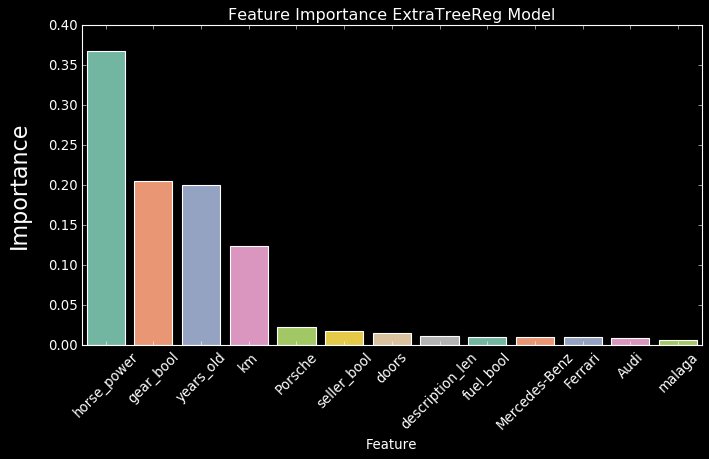

In [140]:
plt.rcParams["figure.figsize"] = (10,5)
imp_pallete = sns.color_palette("Set2")
sns.barplot(x="Feature", y="Importance", data=feature_importance2, palette=imp_pallete)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel("Importance", labelpad=15, fontsize=20)
plt.title("Feature Importance ExtraTreeReg Model")
#plt.savefig("Feature_importance.png", dpi=400, bbox_inches="tight")
plt.show()

## 8. Productionize the model

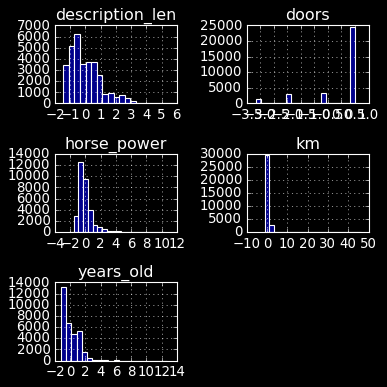

In [141]:
plt.style.use("dark_background")
plt.rcParams["figure.figsize"] = (5,5)
hist_df.iloc[:,:5].hist(bins=20, color="darkblue")
plt.xticks(fontsize=8, color = "k")
plt.tight_layout()
# plt.savefig("hist_features.png", dpi=400)
plt.show()

Next, I will **save, and load the model** as a pickle file, and I will **define a function** that uses the model **to predict the car price** given the horse_power, years_old, km, description_len, seller, location, and brand.

Also, I wil use the median values of the description_len and horse_power as default values, just in case in which we do not have this features about our car.

In [142]:
X.columns

Index(['horse_power', 'years_old', 'km', 'doors', 'description_len',
       'gear_bool', 'seller_bool', 'fuel_bool', 'a coruña', 'alava',
       ...
       'Skoda', 'Smart', 'Ssangyong', 'Subaru', 'Suzuki', 'Talbot', 'Tata',
       'Toyota', 'Volkswagen', 'Volvo'],
      dtype='object', length=120)

In [143]:
X.description_len.median()

548.0

In [285]:
X.to_csv("Data\\X.csv")

In [286]:
X = pd.read_csv("Data\\X.csv")

In [300]:
X = X.drop('Unnamed: 0', axis=1)

In [301]:
X.columns

Index(['horse_power', 'years_old', 'km', 'doors', 'description_len',
       'gear_bool', 'seller_bool', 'fuel_bool', 'a coruña', 'alava',
       ...
       'Skoda', 'Smart', 'Ssangyong', 'Subaru', 'Suzuki', 'Talbot', 'Tata',
       'Toyota', 'Volkswagen', 'Volvo'],
      dtype='object', length=120)

Let's save the model

In [145]:
with open ("Model\\price_car_predictor_brands.pickle", "wb") as f:
    pickle.dump(EtReg,f)

In [146]:
columns = {"data_columns":[col.lower() for col in X.columns]}
with open("Model\\columns.json", "w") as f:
    f.write(json.dumps(columns))

We will also need the standard scaler (scaler_train)

In [199]:
with open ("scaler_train.pickle", "wb") as f:
    pickle.dump(scaler_train,f)

In [91]:
with open("Model/scaler_train.pickle", 'rb') as pickle_scaler:
    scaler_train = pickle.load(pickle_scaler)

with open("Model\\price_car_predictor_brands.pickle", 'rb') as pickle_model:
    model_brand = pickle.load(pickle_model)

def predict_car_price(years_old, km, doors=5, location="Madrid", brand="Audi", 
        horse_power=125, gear=0, seller=0, fuel=1, description_len=548):
# fuel 1 = diesel, fuel 0 = gasoline
# seller 1 = profesional, seller 0 = particular
# gear 1 = automatic, gear 0 = manual

    location = location.lower()
    brand = brand.capitalize()

    x= np.zeros(len(X.columns))
    x[0] = horse_power
    x[1] = years_old
    x[2] = km
    x[3] = doors
    x[4] = description_len
    x[5] = gear
    x[6] = seller
    x[7] = fuel
    
    try: 
        loc_index = np.where(X.columns==location)[0][0] 
        # we use np.where method to loc the index for the location
        
        if loc_index >= 0:
            x[loc_index] = 1
 
    except IndexError:
        pass
    
    try: 
        loc_index2 = np.where(X.columns==brand)[0][0] 
    # X is an np array so we use where method to loc the index for the brand
        

        if loc_index2 >= 0:
            x[loc_index2] = 1
            
    except IndexError:
        pass
    
    x1 = scaler_train.transform(x[:5].reshape(-1, 1).T) 
    # Rescaling non dummy variables
    x2 = x[5:].reshape(-1, 1).T 
    # Dummy variables not rescaled
    x = np.concatenate((x1, x2), axis=1)
        
    return " ".join((str(round(model_brand.predict(x)[0],0)), "Euros"))  

In [100]:
predict_car_price(9, 260000, 5, "zaragoza","opel", seller=0, fuel=1, gear=0, horse_power= 110)

'5802.0 Euros'

Lets taka a quick look on **how price of a given car may change with age**

In [92]:
age = list(range(60))
price1 = []
price2 = []
price3 = []
price4 = []
price5 = []
price6 = []
price7 = []

for i in range(60):
    y1 = predict_car_price(i, 0, 5, brand= "Audi", seller=1, horse_power= 120)
    price1.append(y1)
    
    y2 = predict_car_price(i, 0, 5, brand= "Volkswagen", seller=1, horse_power= 120)
    price2.append(y2)
    
    y3 = predict_car_price(i, 0, 5, brand= "Ferrari", seller=1, horse_power= 120)
    price3.append(y3)
    
    y4 = predict_car_price(i, 0, 5, brand= "Fiat", seller=1, horse_power= 120)
    price4.append(y4)
    
    y5 = predict_car_price(i, 0, 5, brand= "Citroen", seller=1, horse_power= 120)
    price5.append(y5)
    
    y6 = predict_car_price(i, 0, 5, brand= "Honda", seller=1, horse_power= 120)
    price6.append(y6)
    
    y7 = predict_car_price(i, 0, 5, brand= "Mercedes-Benz", seller=1, horse_power= 120)
    price7.append(y7)

In [93]:
price1 = pd.Series(price1, name="Audi").str.replace(" Euros", "")
price2 = pd.Series(price2, name="Volkswagen").str.replace(" Euros", "")
price3 = pd.Series(price3, name="Ferrari").str.replace(" Euros", "")
price4 = pd.Series(price4, name="Fiat").str.replace(" Euros", "")
price5 = pd.Series(price5, name="Citroen").str.replace(" Euros", "")
price6 = pd.Series(price6, name="Honda").str.replace(" Euros", "")
price7 = pd.Series(price6, name="Mercedes-Benz").str.replace(" Euros", "")

In [94]:
price1 = price1.astype(float)
price2 = price2.astype(float)
price3 = price3.astype(float)
price4 = price4.astype(float)
price5 = price5.astype(float)
price6 = price6.astype(float)
price7 = price7.astype(float)

In [95]:
df_aging = pd.concat([price1, price2, price3, price4, price5, price6, price7], axis=1)

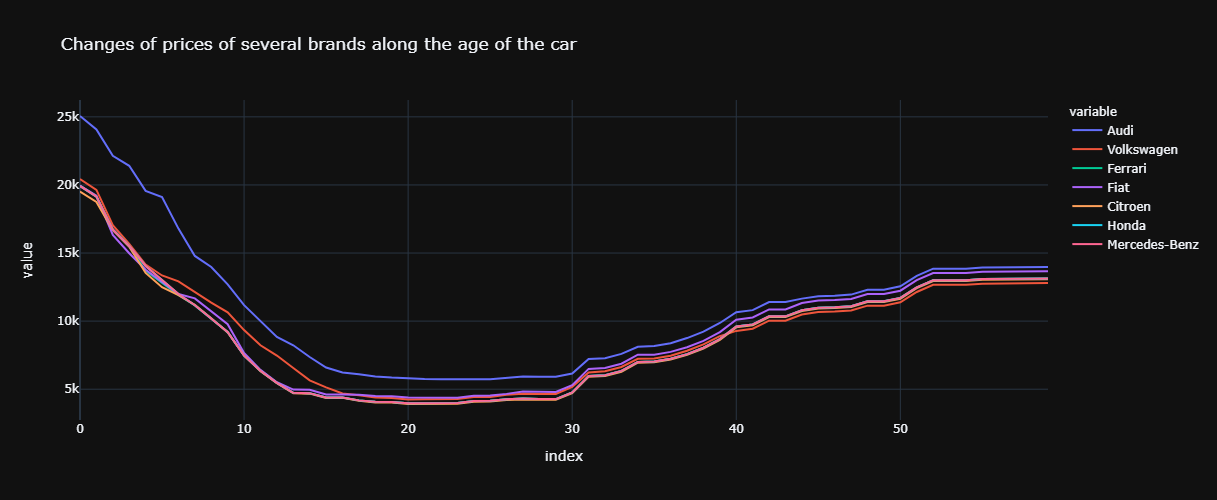

In [110]:
fig = px.line(data_frame = df_aging,
            x=df_aging.index, 
              y=["Audi","Volkswagen","Ferrari","Fiat", "Citroen", "Honda", "Mercedes-Benz"], 
              title='Changes of prices of several brands along the age of the car ',
             template="plotly_dark", width=700, height=500)
fig.show()

Interestingly, we see how during the first 10 years, cars appear to loose more than **half their value**, and their price decreases more slowly after that. Therefore, buying 10 year-old cars may be the best idea 👍🏼